In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Task 1: Image Inpainting using GANs**

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [ ]:
tf.compat.v1.reset_default_graph()

### Function Definitions for GANs

In [ ]:
import tensorflow as tf
import cv2 as cv
import random
import os
import math
import numpy as np

def random_interpolates(x, y, alpha=None):
    """
    x: first dimension as batch_size
    y: first dimension as batch_size
    alpha: [BATCH_SIZE, 1]
    """
    shape = x.get_shape().as_list()
    x = tf.reshape(x, [shape[0], -1])
    y = tf.reshape(y, [shape[0], -1])
    if alpha is None:
        alpha = tf.compat.v1.random_uniform(shape=[shape[0], 1])
    interpolates = x + alpha*(y - x)
    return tf.reshape(interpolates, shape)


def gradients_penalty(x, y, mask=None, norm=1.):
    """Improved Training of Wasserstein GANs
    - https://arxiv.org/abs/1704.00028
    """
    gradients = tf.gradients(y, x)[0]
    if mask is None:
        mask = tf.ones_like(gradients)
    slopes = tf.sqrt(tf.reduce_mean(tf.square(gradients) * mask, axis=[1, 2, 3]))
    return tf.reduce_mean(tf.square(slopes - norm))


def standard_conv(x,mask,cnum,ksize=3,stride=1,rate=1,name='conv',padding='SAME'):
        '''
        define convolution for generator
        Args:
                x:iput image
                cnum: channel number
                ksize: kernal size
                stride: convolution stride
                rate : rate for dilated conv
                name: name of layers
        '''
        p       = int(rate*(ksize-1)/2)
        x       = tf.pad(x, [[0,0], [p, p], [p, p], [0,0]],'REFLECT')
        padding = 'VALID'
        x       = tf.compat.v1.layers.conv2d(x,cnum,ksize,stride,dilation_rate=rate,activation=tf.nn.elu
                                  ,padding=padding,name=name+'_1')
        return x
def standard_dconv(x,mask,cnum,name='deconv',padding='VALID'):
        '''
        define upsample convolution for generator
        Args:
        x: input image
        mask: input mask
        name: name of layers
        '''
        rate   = 1
        ksize  = 3
        stride = 1
        shape  = x.get_shape().as_list()
        x      = tf.compat.v1.image.resize_nearest_neighbor(x,[shape[1]*2,shape[2]*2])
        p3     = int(1 * (3 - 1) / 2)
        x      = tf.pad(x, [[0,0], [p3,p3], [p3,p3], [0,0]], 'REFLECT')
        x      = tf.compat.v1.layers.conv2d(x,cnum,ksize,stride,dilation_rate=rate,activation=tf.nn.elu
                                          ,padding=padding,name=name+'_1')
        return x


def l2_norm(v, eps=1e-12):
    return v / (tf.reduce_sum(v ** 2) ** 0.5 + eps)


def spectral_norm(w, iteration=1,name='dasd'):
   w_shape = w.shape.as_list()
   w = tf.reshape(w, [-1, w_shape[-1]])

   u = tf.compat.v1.get_variable(name+"u", [1, w_shape[-1]], initializer=tf.compat.v1.truncated_normal_initializer(), trainable=False)

   u_hat = u
   v_hat = None
   for i in range(0, iteration):
       v_ = tf.matmul(u_hat, tf.transpose(w))
       v_hat = l2_norm(v_)

       u_ = tf.matmul(v_hat, w)
       u_hat = l2_norm(u_)

   sigma = tf.matmul(tf.matmul(v_hat, w), tf.transpose(u_hat))
   w_norm = w / sigma

   with tf.control_dependencies([u.assign(u_hat)]):
       w_norm = tf.reshape(w_norm, w_shape)

   return w_norm


def LeakyRelu(x, leak=0.2, name="LeakyRelu"):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * tf.abs(x)


def dis_conv(x, cnum, ksize=5, stride=2, activation = 'leak_relu', name='conv'):
    """
    covolution for discriminator.
    Args:
        x: input image
        cnum: channel number.
        ksize: kernel size.
        Stride: convolution stride.
        name: name of layers.
    """

    x_shape = x.get_shape().as_list()
    w = tf.compat.v1.get_variable(name = name+'_w',shape = [ksize, ksize, x_shape[-1]] + [cnum])
    w = spectral_norm(w, name = name)
    x = tf.nn.conv2d(x, w, strides = [1, stride, stride, 1], padding = 'SAME')
    bias = tf.compat.v1.get_variable(name=name+'_bias',shape=[cnum])
    if activation != None:
        return  LeakyRelu(x + bias, name = name)
    else:
        return x + bias

-1

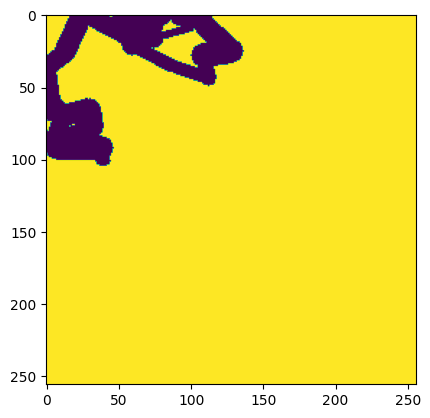

In [ ]:
from random import randint
import itertools
import numpy as np
import cv2
from math import *
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

def continuous_mask(height, width,num,maxAngle,maxLength,maxBrushWidth,channels=3):
    """Generates a continuous mask with lines, circles and elipses"""

    img = np.zeros((height, width, channels), np.uint8)

    for j in range(0, 1):
        startX = randint(0, width)
        startY = randint(0, height)
        for i in range(0,randint(1,num)):
            angle = randint(0,maxAngle)
            if i%2==0:
                angle = 360 - angle
            length = randint(1,maxLength)
            brushWidth = randint(1, maxBrushWidth)
            endX   = startX + int(length * sin(angle))
            endY   = startY + int(length * cos(angle))
            if endX>255:
                endX = 255
            if endX<0:
                endX = 0
            if endY>255:
                endY = 255
            if endY<0:
                endY = 0
            cv2.line(img, (startX,startY),(endX,endY),(255,255,255),brushWidth)
            cv2.circle(img, (endX,endY),brushWidth//2,(255,255,255),-1)
            startY = endY
            startX = endX


    img2 = np.zeros((height, width,1))
    img2[:, :,0] = img[:, :, 0]
    img2[img2>1] = 1

    return 1-img2



def discontinuous_mask(height, width,num,low,high,channels=3):
    """Generates a discontinuous mask with lines, circles and elipses
       When we were training, we generated more elipses
    """
    img = np.zeros((height, width, channels), np.uint8)

    # Set size scale
    size = int((width + height) * 0.1)
    if width < 64 or height < 64:
        raise Exception("Width and Height of mask must be at least 64!")

    # Draw random lines
    for _ in range(0, randint(1, num)):
        x1, x2 = randint(1, width), randint(1, width)
        y1, y2 = randint(1, height), randint(1, height)
        thickness = randint(3, size)
        cv2.line(img,(x1,y1),(x2,y2),(1,1,1),thickness)

    # Draw random circles
    for _ in range(0, randint(1, num)):
        x1, y1 = randint(1, width), randint(1, height)
        radius = randint(3, size)
        cv2.circle(img,(x1,y1),radius,(1,1,1), -1)

    # Draw randow rectangle
    for _ in range(0, randint(1, num)):
        x1,y1 = randint(1, width), randint(1, height)
        x2,y2 = randint(1, width), randint(1, height)
        cv2.rectangle(img, (x1, y1), (x2, y2), (1, 1, 1), -1)

    # Draw random ellipses
    for _ in range(0, randint(1, num)):
        x1, y1 = randint(1, width), randint(1, height)
        s1, s2 = randint(low, high), randint(low, high)
        a1, a2, a3 = randint(3, 180), randint(3, 180), randint(3, 180)
        thickness = randint(3, size)
        cv2.ellipse(img, (x1,y1), (s1,s2), a1, a2, a3,(1,1,1), thickness)

    img2 = np.zeros((height, width,1))
    img2[:, :,0] = img[:, :, 0]
    img2[img2>1] = 1

    return img2


mask = continuous_mask(256, 256, 60, 270, 32, 15)
plt.imshow(mask)
#print(mask)
cv2.waitKey(0)

In [ ]:
import tensorflow as tf
import cv2 as cv
import numpy as np

def region_deconv(x_complete, x_missing, mask,name = 'com_'):
    shape = x_complete.get_shape().as_list()
    mask = tf.compat.v1.image.resize_nearest_neighbor(mask, size = [shape[1], shape[2]], align_corners=True)
    mask = tf.reshape(mask, [shape[0], shape[1], shape[2], 1])
    x_complete = x_complete * mask
    shape = x_missing.get_shape().as_list()
    x_missing  = x_missing  * (1 - mask)
    x_fusion   = tf.concat([x_complete,x_missing], axis = -1)

    x_fusion   = standard_dconv(x_fusion,mask,shape[-1],name = name+"_fusion")
    return x_fusion

def region_conv(x_complete, x_missing, mask,name = 'com_'):
    shape = x_complete.get_shape().as_list()
    mask = tf.compat.v1.image.resize_nearest_neighbor(mask, size = [shape[1], shape[2]], align_corners=True)
    mask = tf.reshape(mask, [shape[0], shape[1], shape[2], 1])
    p3 = int(1 * (3 - 1) / 2)

    x_complete = x_complete * mask
    shape = x_missing.get_shape().as_list()
    x_missing  = x_missing  * (1 - mask)
    x_fusion   = tf.concat([x_complete,x_missing], axis = -1)
    x_fusion   = tf.pad(x_fusion, [[0,0], [p3,p3], [p3,p3], [0,0]], 'REFLECT')

    x_fusion   = tf.compat.v1.layers.conv2d(x_fusion, shape[-1], kernel_size = 3, strides = 1, padding = 'VALID', dilation_rate = 1, name = name + "_fusion")
    x_fusion   = tf.nn.elu(x_fusion)
    return x_fusion

In [ ]:
import inspect
import os

import numpy as np
import tensorflow as tf
import time

VGG_MEAN = [103.939, 116.779, 123.68]


class Vgg16:
    def __init__(self, vgg16_npy_path=None):
        if vgg16_npy_path is None:
            path = inspect.getfile(Vgg16)
            path = os.path.abspath(os.path.join(path, os.pardir))
            path = os.path.join(path, "vgg16.npy")
            vgg16_npy_path = path
            print(path)

        self.data_dict = np.load(vgg16_npy_path, encoding='latin1', allow_pickle=True).item()
        print("npy file loaded")

    def build(self, rgb):
        """
        load variable from npy to build the VGG
        :param rgb: rgb image [batch, height, width, 3] values scaled [0, 1]
        """

        start_time = time.time()
        rgb = tf.compat.v1.image.resize_images(rgb, (224, 224))
        print("build model started")
        rgb_scaled = (rgb+1.) * 127.5
        #print(type(rgb[0][0][0][0]))

        # Convert RGB to BGR
        # red, green, blue = tf.split(3, 3, rgb_scaled)
        red, green, blue = tf.split(rgb_scaled, 3, 3)
        assert red.get_shape().as_list()[1:] == [224, 224, 1]
        assert green.get_shape().as_list()[1:] == [224, 224, 1]
        assert blue.get_shape().as_list()[1:] == [224, 224, 1]
        bgr = tf.concat([
            blue - VGG_MEAN[0],
            green - VGG_MEAN[1],
            red - VGG_MEAN[2],
        ], 3)
        assert bgr.get_shape().as_list()[1:] == [224, 224, 3]

        self.conv1_1 = self.conv_layer(bgr, "conv1_1")
        self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
        self.pool1 = self.max_pool(self.conv1_2, 'pool1')

        self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
        self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
        self.pool2 = self.max_pool(self.conv2_2, 'pool2')

        self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
        self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
        self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
        self.pool3 = self.max_pool(self.conv3_3, 'pool3')

        self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
        self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
        self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")
        self.pool4 = self.max_pool(self.conv4_3, 'pool4')

        self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
        self.conv5_2 = self.conv_layer(self.conv5_1, "conv5_2")
        self.conv5_3 = self.conv_layer(self.conv5_2, "conv5_3")
        self.pool5 = self.max_pool(self.conv5_3, 'pool5')


        print("build model finished: %ds" % (time.time() - start_time))

    def avg_pool(self, bottom, name):
        return tf.nn.avg_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def max_pool(self, bottom, name):
        return tf.nn.max_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def conv_layer(self, bottom, name):
        with tf.compat.v1.variable_scope(name):
            filt = self.get_conv_filter(name)

            conv = tf.nn.conv2d(bottom, filt, [1, 1, 1, 1], padding='SAME')

            conv_biases = self.get_bias(name)
            bias = tf.nn.bias_add(conv, conv_biases)

            relu = tf.nn.relu(bias)
            return relu

    def fc_layer(self, bottom, name):
        with tf.compat.v1.variable_scope(name):
            shape = bottom.get_shape().as_list()
            dim = 1
            for d in shape[1:]:
                dim *= d
            x = tf.reshape(bottom, [-1, dim])

            weights = self.get_fc_weight(name)
            biases = self.get_bias(name)

            # Fully connected layer. Note that the '+' operation automatically
            # broadcasts the biases.
            fc = tf.nn.bias_add(tf.matmul(x, weights), biases)

            return fc

    def get_conv_filter(self, name):
        return tf.constant(self.data_dict[name][0], name="filter")

    def get_bias(self, name):
        return tf.constant(self.data_dict[name][1], name="biases")

    def get_fc_weight(self, name):
        return tf.constant(self.data_dict[name][0], name="weights")

def loss_perceptual(pic1, pic2, pic3):
    loss = 0

    for o, c, g in zip(pic2, pic3, pic1):
        loss += l1(o, g) + l1(c, g)
    return loss

def l1(pic1, pic2):
    return tf.reduce_sum(tf.abs(pic1 - pic2))

def gram_matrix(x):
    shape = tf.shape(x)
    B, H, W, C = shape[0], shape[1], shape[2], shape[3]
    features = tf.reshape(x, tf.stack([B, -1, C]))
    gram = tf.matmul(features, features, transpose_a=True)
    gram = gram / tf.cast(C * H * W, x.dtype)
    return gram
def new_gram(x):
    shape = tf.shape(x)
    B, H, W, C = shape[0], shape[1], shape[2], shape[3]
    features = tf.reshape(x, tf.stack([B, -1, C]))
    gram = tf.matmul(features, features, transpose_b=True)
    gram = gram / tf.cast(C * C, x.dtype)
    return gram
def loss_style(output, vgg_gt):
    loss = 0
    for o, g in zip(output, vgg_gt):
        loss += l1(gram_matrix(o), gram_matrix(g))
    return loss

def loss_cor(output, vgg_gt):
    loss = 0
    loss_new = l1(new_gram(output[1]), new_gram(vgg_gt[1]))
    return loss_new

In [ ]:
import tensorflow as tf
import cv2 as cv
import numpy as np

def RW_generator(x,mask,padding='SAME',name='inpaint_net',reuse=False):
    '''
    Region-wise generator
    Args:
            x: incomplete image
            mask: mask region {0,1}
    returns:
            predicted image
    '''
    x1 = SINet(x, mask, reuse=reuse)
    x_combine = x * mask + x1 * (1 - mask)
    x2 = GPNet(x_combine,mask, reuse=reuse)
    return x1, x2

def SINet(x,mask,padding='SAME',name='inpaint_net',reuse=False):
    '''
    Semantic inferring network
    Args:
            x: incomplete image
            mask: mask region {0,1}
    returns:
            image predicted by semantic inferring network
    '''
    xin=x;
    mask_in=mask
    cnum=32
    ones_x = tf.ones_like(x)[:, :, :, 0:1]
    x = tf.concat([x, mask], axis=3)
    with tf.compat.v1.variable_scope(name,reuse=reuse):
            x1=standard_conv(x,mask,cnum,5,1,name='conv1')
            x2=standard_conv(x1,mask,2*cnum,3,2,name='conv2_downsample')
            x3=standard_conv(x2,mask,2*cnum,3,1,name='conv3')
            x4=standard_conv(x3,mask,4*cnum,3,2,name='conv4_downsample')
            x5=standard_conv(x4,mask,4*cnum,3,1,name='conv5')
            x6=standard_conv(x5,mask,4*cnum,3,1,name='conv6')

            #dilated conv
            x7=standard_conv(x6,mask,4*cnum,3,rate=2,name='conv7_atrous')
            x8=standard_conv(x7,mask,4*cnum,3,rate=4,name='conv8_atrous')
            x9=standard_conv(x8,mask,4*cnum,3,rate=8,name='conv9_atrous')
            x10=standard_conv(x9,mask,4*cnum,3,rate=16,name='conv10_atrous')



            x11=standard_conv(tf.concat([x10,x6],axis=-1), mask,4*cnum,3,1,name='conv11')
            x12=standard_conv(tf.concat([x11,x5],axis=-1),mask,4*cnum,3,1,name='conv12')

            x_complete, x_missing = tf.concat([x12,x4],axis=-1),x12
            x13 = region_deconv(x_complete, x_missing, mask,name = 'com_13')

            x_complete, x_missing = tf.concat([x13,x3],axis=-1),x13
            x14 = region_conv(x_complete,x_missing,mask,name='com_14')

            x_complete, x_missing = tf.concat([x14,x2],axis=-1),x14
            x15 = region_deconv(x_complete, x_missing, mask, name = 'com_15')

            x16 = standard_conv(x15,mask,cnum,3,1,name='conv16')

            x17=standard_conv(x16,mask,cnum//2,3,1,name='conv17')
            x18=standard_conv(x17,mask,3,3,1,name='conv18')
            x18=tf.clip_by_value(x18,-1.,1.)

            return x18
def GPNet(x,mask,padding='SAME',name='inpaint_net_1',reuse=False):
    '''
    Global perceiving network
    Args:
            x: incomplete image
            mask: mask region {0,1}
    returns:
            image predicted by global perceiving network
    '''
    xin=x;
    mask_in=mask
    cnum=32
    x = tf.concat([x, mask], axis=3) #concat
    with tf.compat.v1.variable_scope(name,reuse=reuse):
            x1=standard_conv(x,mask,cnum,5,1,name='conv1')
            x2=standard_conv(x1,mask,2*cnum,3,2,name='conv2_downsample')
            x3=standard_conv(x2,mask,2*cnum,3,1,name='conv3')
            x4=standard_conv(x3,mask,4*cnum,3,2,name='conv4_downsample')
            x5=standard_conv(x4,mask,4*cnum,3,1,name='conv5')
            x6=standard_conv(x5,mask,4*cnum,3,1,name='conv6')

            #dilated conv
            x7=standard_conv(x6,mask,4*cnum,3,rate=2,name='conv7_atrous')
            x8=standard_conv(x7,mask,4*cnum,3,rate=4,name='conv8_atrous')
            x9=standard_conv(x8,mask,4*cnum,3,rate=8,name='conv9_atrous')
            x10=standard_conv(x9,mask,4*cnum,3,rate=16,name='conv10_atrous')



            x11=standard_conv(tf.concat([x10,x6],axis=-1), mask,4*cnum,3,1,name='conv11')
            x12=standard_conv(tf.concat([x11,x5],axis=-1),mask,4*cnum,3,1,name='conv12')

            x13=standard_dconv(tf.concat([x12,x4],axis=-1),mask,2*cnum,name='conv13_upsample')
            x14=standard_conv(tf.concat([x13,x3],axis=-1),mask,2*cnum,3,1,name='conv14')
            x15=standard_dconv(tf.concat([x14,x2],axis=-1),mask,cnum,name='conv15_upsample')
            x16=standard_conv(tf.concat([x15,x1],axis=-1),mask,cnum//2,3,1,name='conv16')
            x17=standard_conv(x16,mask,3,3,1,name='conv17')
            x18=tf.clip_by_value(x17,-1.,1.)

            return x18

def RW_discriminator(x, mask, batch_size, activation = 'leaky_relu',reuse=False):
    '''
    Region-wise discriminator
    Args:
            x: input images
            mask: mask region {0,1}
    returns:
            matrix {real, fake}
    '''
    with tf.compat.v1.variable_scope('discriminator',reuse=reuse):
            cnum=64
            x=tf.concat([x,mask],axis=3)
            x=dis_conv(x,cnum,name='d_conv1')
            x=dis_conv(x,2*cnum,name='d_conv2')
            x=dis_conv(x,4*cnum,name='d_conv3')
            x=dis_conv(x,4*cnum,name='d_conv4')
            x=dis_conv(x,4*cnum,name='d_conv5')
            x=dis_conv(x,4*cnum,name='d_conv6', activation = activation)
            return x
def build_graph_with_loss(batch_data, batch_size, mask, vgg_path, adv_type, stage = 0,
                         lambda_style = 0.001, lambda_cor = 0.00001, alpha = 0.01 ,lambda_adv = 1.0,
                         reuse=False, training = True):

    image_gt=tf.subtract(tf.divide(batch_data,127.5),1.)
    date_shape=batch_data.get_shape().as_list()
    batch_incomplete=image_gt*mask

    image_p1, image_p2 = RW_generator(batch_incomplete, mask)
    image_c1 = image_p1 * (1 - mask) + image_gt * mask
    image_c2 = image_p2 * (1 - mask) + image_gt * mask
    rec_loss = tf.reduce_sum(tf.abs(image_gt - image_p1)) + tf.reduce_sum(tf.abs(image_gt - image_p2))

    vgg = Vgg16(vgg_path)
    vgg.build(image_gt)
    vgg_pos = [vgg.pool1,vgg.pool2, vgg.pool3]
    vgg.build(image_c1)
    vgg_x1 =  [vgg.pool1,vgg.pool2, vgg.pool3]
    vgg.build(image_c2)
    vgg_x2 =  [vgg.pool1,vgg.pool2, vgg.pool3]

    cor_loss = loss_cor(vgg_x1, vgg_pos)
    style_loss= loss_style(vgg_x2, vgg_pos)
    cor_loss = cor_loss * lambda_cor
    style_loss = style_loss * lambda_style
    cor_style = cor_loss + style_loss


    if stage == 1:
        activation = None
        if adv_type == ' ':
            activation = 'leaky_relu'
        d_pred = RW_discriminator(image_c1 * (1 - mask), mask, batch_size, activation)
        d_pred2 = RW_discriminator(image_c2 * (1 - mask), mask, batch_size, activation, reuse = True)
        d_real = RW_discriminator(image_gt * (1 - mask), mask, batch_size, activation, reuse = True)
        mask_label = 1 - mask
        shape = d_pred.get_shape().as_list()
        mask_label =  tf.compat.v1.image.resize_nearest_neighbor(mask_label, [shape[1],shape[2]])
        if adv_type == 'wgan':
            penalty_img = random_interpolates(image_gt, image_c2)
            dout_penalty = RW_discriminator(penalty_img, mask, batch_size, activation,reuse = True)
            penalty_loss = gradients_penalty(penalty_img, dout_penalty, mask = mask)
            adv_d_loss =  tf.reduce_mean(d_pred * mask_label) + tf.reduce_mean(d_pred2 * mask_label) - 0.01 * tf.reduce_mean(d_real * mask_label) +penalty_loss
            adv_g_loss = -1 * tf.reduce_mean(d_pred * mask_label) - tf.reduce_mean(d_pred2 * mask_label)

        elif adv_type == 'gan':
            adv_d_loss = 0.01 * tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real, labels=tf.ones_like(d_real)) * mask_label) + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_pred, labels=tf.zeros_like(d_pred)) * mask_label) + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_pred2, labels=tf.zeros_like(d_pred2))* mask_label)
            adv_g_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_pred, labels=tf.ones_like(d_real)) * mask_label)  + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_pred2, labels=tf.ones_like(d_real)) * mask_label)

        elif adv_type == 'hinge':

            adv_d_loss =  0.01 * tf.reduce_mean(tf.nn.relu(1 - d_real) * mask_label) + tf.reduce_mean(tf.nn.relu(1 + d_pred) * mask_label)
            + tf.reduce_mean(tf.nn.relu(1 + d_pred2) * mask_label)
            adv_g_loss = -1 * tf.reduce_mean(tf.nn.relu(d_pred) * mask_label) - tf.reduce_mean(tf.nn.relu(d_pred2) * mask_label)
        else:

            adv_d_loss =  alpha*tf.reduce_sum(tf.abs(mask_label - d_real)) + tf.reduce_sum(tf.abs(0 - d_pred)) + tf.reduce_sum(tf.abs(0 - d_pred2))
            adv_g_loss = tf.reduce_sum(tf.abs(mask_label - d_pred)) + tf.reduce_sum(tf.abs(mask_label - d_pred2))
    else:
        adv_d_loss = None
        adv_g_loss = None

    if stage == 1:
        g_loss= rec_loss+cor_style + lambda_adv * adv_g_loss
    else:
        g_loss = rec_loss + cor_style
    g_vars=tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES,'inpaint_net')
    d_vars=tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES,'discriminator') if stage == 1 else None

    tf.compat.v1.summary.image('incomplete',batch_incomplete, max_outputs=7)
    tf.compat.v1.summary.image('image_p1',image_p1, max_outputs=7)
    tf.compat.v1.summary.image('image_p2',image_p2, max_outputs=7)
    tf.compat.v1.summary.image('image_c2',image_c2, max_outputs=7)
    tf.compat.v1.summary.scalar('rec_loss',rec_loss)
    tf.compat.v1.summary.scalar('correlation loss', cor_loss)
    tf.compat.v1.summary.scalar('style loss', style_loss)
    if stage == 1:
        tf.compat.v1.summary.scalar('adv_g_loss', adv_g_loss)
        tf.compat.v1.summary.scalar('adv_d_loss', adv_d_loss)
    return g_vars,d_vars,g_loss,adv_d_loss,rec_loss,cor_loss,style_loss

## Training Block for GANs

In [ ]:
from tensorflow.python import pywrap_tensorflow
import math
import random
import gc
import os
import cv2
import glob
import socket
import tensorflow as tf
import argparse

train_data_path = "/content/drive/MyDrive/DL_Milestone_2/images"
epoch = 20
batch_size=8
width = 256
height = 256
mask_area = 60
learning_rate = 0.0003
beta1 = 0.5
beta2 = 0.9
lambda_style = 0.001
lambda_cor = 0.00001
lambda_adv = 1.0
alpha = 0.001
stage = 1
discriminator_train = 0
mask_type = 1
pretrained_model = "/content/drive/MyDrive/DL_Milestone_2/output/model_new/latest_checkpoint"
adv_type = 'gan'
vgg_path = "/content/drive/MyDrive/DL_Milestone_2/vgg16.npy"
output = "/content/drive/MyDrive/DL_Milestone_2/output"

fnames = glob.glob(train_data_path + '/*.png')
filename_queue = tf.compat.v1.train.string_input_producer(fnames, shuffle = True)
reader = tf.compat.v1.WholeFileReader()
_,img_bytes = reader.read(filename_queue)
images = tf.image.decode_png(img_bytes, channels = 3)
images = tf.compat.v1.image.resize_images(images,[height, width])
images = tf.compat.v1.train.batch([images],batch_size, dynamic_pad = True)
mask   = tf.compat.v1.placeholder(tf.float32,[batch_size, height, width, 1], name = 'mask')


In [ ]:
sess = tf.compat.v1.Session()
if discriminator_train == 0:
  g_vars, _, adv_g_loss, _,rec_loss, correlation_loss, style_loss = build_graph_with_loss(images, batch_size, mask, vgg_path, adv_type, discriminator_train, lambda_style, lambda_cor, alpha, lambda_adv)
else:
  g_vars, d_vars, adv_g_loss, adv_d_loss, rec_loss, correlation_loss, style_loss = build_graph_with_loss(images, batch_size, mask, vgg_path, adv_type, discriminator_train, lambda_style, lambda_cor, alpha , lambda_adv)
  d_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = 0.0001, beta1 = 0.5, beta2 = 0.9).minimize(adv_d_loss, var_list = d_vars)
g_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = 0.0003, beta1 = 0.5, beta2 = 0.9).minimize(adv_g_loss, var_list = g_vars)

init_op = tf.group(tf.compat.v1.initialize_all_variables(), tf.compat.v1.initialize_local_variables()) # tf.initialize_all_variables()
sess.run(init_op)
if stage == 1:
  saver_pre = tf.compat.v1.train.Saver(g_vars)
  saver_pre.restore(sess, pretrained_model)

tf.compat.v1.train.start_queue_runners(sess)
summarywriter = tf.compat.v1.summary.FileWriter(output + '/summary', tf.compat.v1.get_default_graph())
merge = tf.compat.v1.summary.merge_all()
Iters = int(len(fnames)/batch_size)
saver = tf.compat.v1.train.Saver(max_to_keep=5)
low   = 0
it    = 0
high=height
num=mask_area
for j in range(0,10):
  mask_type=1
  for i in range(0, Iters):
    if mask_type == 0:
      mask_ = np.stack([discontinuous_mask(height,width,num,low,high) for _ in range(0, batch_size)], axis=0)
    else:
      mask_ = np.stack([continuous_mask(height,width, num,360,32,15) for _ in range(0, batch_size)], axis=0)
    if discriminator_train == 0:
       _,g,rec,closs,sloss=sess.run([g_optimizer,adv_g_loss,rec_loss,correlation_loss,style_loss],feed_dict={mask:mask_,})
    else:
       _,_,g,d,rec,closs,sloss=sess.run([g_optimizer,d_optimizer,adv_g_loss,adv_d_loss,rec_loss,correlation_loss,style_loss],feed_dict={mask:mask_,})
    if i % 20==0:
      if discriminator_train == 0:
        print('[{}/{}]rec_loss: {} correlation_loss:{}  style_loss: {}'.format(i,Iters,rec,closs,sloss))
      else:
        print('[{}/{}]g_loss: {}  rec_loss: {} correlation_loss:{}  style_loss: {} d_loss: {}'.format(i,Iters,g,rec,closs,sloss,d))
    it += 1
  saver.save(sess, "/content/drive/MyDrive/DL_Milestone_2/output/model_new/latest_checkpoint")

## Test Block for GANs

In [ ]:
def infer(batch_data,mask,reuse=False):
        shape=batch_data.get_shape().as_list()
        batch_gt=batch_data/127.5-1.
        batch_incomplete=batch_gt*mask

        image_p1, image_p2=RW_generator(batch_incomplete,mask,reuse=reuse)

        image_c2=batch_incomplete*mask+ image_p2*(1.-mask)
        image_c2=(image_c2+1.)*127.5
        return image_c2

In [ ]:
def calculate_psnr(img1, img2):
    # Read images
    image1 = cv2.imread(img1)
    image2 = cv2.imread(img2)

    # Ensure images have the same shape
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same dimensions")

    # Calculate MSE (Mean Squared Error)
    mse = np.mean((image1 - image2) ** 2)

    # Calculate PSNR (Peak Signal-to-Noise Ratio)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [ ]:
from skimage.metrics import structural_similarity as ssim
def calculate_ssim(img1, img2):
    # Read images
    image1 = cv2.imread(img1)
    image2 = cv2.imread(img2)

    # Ensure images have the same shape
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same dimensions")

    # Convert images to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Calculate SSIM
    ssim_index, _ = ssim(gray1, gray2, full=True)
    return ssim_index

In [ ]:
images=tf.compat.v1.placeholder(tf.float32,[1,256,256,3],name = 'image')
mask=tf.compat.v1.placeholder(tf.float32,[1,256,256,1],name='mask')
sess = tf.compat.v1.Session()
inpainting_result=infer(images,mask)
saver_pre=tf.compat.v1.train.Saver()
init_op = tf.group(tf.compat.v1.initialize_all_variables(),tf.compat.v1.initialize_local_variables())

### Inpainting Validation Data

In [ ]:
psnr_values_validation = []
ssim_values_validation = []

In [ ]:
import random
import gc
import os
import cv2
import glob
import socket
import tensorflow as tf
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

corrupted_image_folder = "DL_Milestone_2/train_val/validation_paired/Earthquake"
actual_images_folder = "DL_Milestone_2/train_val/validation/Earthquake"

corrupted_image_files = [f for f in os.listdir(os.path.join('/content/drive/MyDrive', corrupted_image_folder)) if f.endswith('.png')]
actual_image_files = [f for f in os.listdir(os.path.join('/content/drive/MyDrive', actual_images_folder)) if f.endswith('.png')]
common_files = set(corrupted_image_files) & set(actual_image_files)

for file_name in common_files:
  test_data_path = os.path.join('/content/drive/MyDrive', corrupted_image_folder, file_name)
  corrupted_image = cv2.imread(test_data_path)

  difference_image_gray = cv2.cvtColor(corrupted_image, cv2.COLOR_BGR2GRAY)

  mask_test = 255-cv2.threshold(difference_image_gray, 1, 255, cv2.THRESH_BINARY)[1]
  mask_test = mask_test.reshape((256,256,1))

  cv2.imwrite('/content/mask.png', mask_test)

  mask_path = "/content/mask.png"
  model_path = "/content/drive/MyDrive/DL_Milestone_2/output/model_new/latest_checkpoint"
  file_out = "DL_Milestone_2/validation_inpainted/Earthquake"
  file_out_2 = "DL_Milestone_2/validation_inpainted_2/Earthquake"
  width = 256
  height = 256
  file_test=test_data_path
  file_mask=mask_path
  sess.run(init_op)
  saver_pre.restore(sess, model_path)

  test_mask = cv2.resize(cv2.imread(file_mask),(height,width))
  test_mask = test_mask[:,:,0:1]
  test_mask = 0. + test_mask//255
  test_mask[test_mask >= 0.5] = 1
  test_mask[test_mask <  0.5] = 0
  test_mask  = 1-test_mask
  test_image = cv2.imread(file_test)[...,::-1]
  test_image = cv2.resize(test_image, (height, width))
  test_mask = np.expand_dims(test_mask,0)
  test_image = np.expand_dims(test_image,0)
  img_out=sess.run(inpainting_result,feed_dict={mask:test_mask,images:test_image})

  out_address = os.path.join('/content/drive/MyDrive', file_out, file_name)
  out_address_2 = os.path.join('/content/drive/MyDrive', file_out_2, file_name)
  cv2.imwrite(out_address, img_out[0][...,::-1])
  cv2.imwrite(out_address_2, test_image[0][...,::-1] * test_mask[0] + 255 * (1 - test_mask[0]))

  actual_image_path = os.path.join('/content/drive/MyDrive', actual_images_folder, file_name)
  new_image_path = out_address
  actual_image = cv2.imread(actual_image_path)
  actual_image = cv2.resize(actual_image, (256, 256), interpolation = cv2.INTER_LINEAR)
  actual_image = actual_image.reshape((256,256,3))
  new_image = cv2.imread(new_image_path)
  cv2.imwrite('/content/image.png', actual_image)
  psnr = calculate_psnr('/content/image.png', new_image_path)
  print(f'PSNR: {psnr} dB')
  psnr_values_validation.append(psnr)
  ssim_value = calculate_ssim('/content/image.png', new_image_path)
  print(f'SSIM: {ssim_value:.5f}')
  ssim_values_validation.append(ssim_value)

PSNR: 48.57806277260116 dB
SSIM: 0.99092
PSNR: 41.253359843102274 dB
SSIM: 0.95738
PSNR: 43.295992508919134 dB
SSIM: 0.96340
PSNR: 41.677837291795555 dB
SSIM: 0.94900
PSNR: 35.27581815821285 dB
SSIM: 0.94415
PSNR: 45.079741869049045 dB
SSIM: 0.98808
PSNR: 42.34671617465881 dB
SSIM: 0.96727
PSNR: 45.315237333233725 dB
SSIM: 0.97931
PSNR: 44.131075943551906 dB
SSIM: 0.97587
PSNR: 34.7204791788134 dB
SSIM: 0.93350
PSNR: 33.954348764985525 dB
SSIM: 0.97526
PSNR: 32.79490034208541 dB
SSIM: 0.92267
PSNR: 41.806247781661305 dB
SSIM: 0.95992
PSNR: 44.61969270059725 dB
SSIM: 0.98390
PSNR: 39.700262866388954 dB
SSIM: 0.92934
PSNR: 40.58006342970976 dB
SSIM: 0.93871
PSNR: 40.69635720773302 dB
SSIM: 0.94619
PSNR: 42.376523488236415 dB
SSIM: 0.96065
PSNR: 35.82984362917086 dB
SSIM: 0.93845
PSNR: 34.9577875693251 dB
SSIM: 0.91089
PSNR: 33.024866886194225 dB
SSIM: 0.92464
PSNR: 33.91313404964923 dB
SSIM: 0.92084
PSNR: 37.22828136264906 dB
SSIM: 0.91896
PSNR: 44.2249800062951 dB
SSIM: 0.97801
PSNR: 33

In [ ]:
for i in range(len(psnr_values_validation)):
  if(psnr_values_validation[i]==inf):
    print(i)
    psnr_values_validation[i] = 72.0

1174
1192


In [ ]:
average_psnr = np.mean(psnr_values_validation)
print(f"Average PSNR: {average_psnr}")

average_ssim = np.mean(ssim_values_validation)
print(f"Average SSIM: {average_ssim}")

Average PSNR: 41.393762732390925
Average SSIM: 0.9482967585106814


### Inpainting Train Data

In [ ]:
psnr_values_train = []
ssim_values_train = []

In [ ]:
import random
import gc
import os
import cv2
import glob
import socket
import tensorflow as tf
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

corrupted_image_folder = "DL_Milestone_2/train_val/train_paired/Earthquake"
actual_images_folder = "DL_Milestone_2/train_val/train/Earthquake"

corrupted_image_files = [f for f in os.listdir(os.path.join('/content/drive/MyDrive', corrupted_image_folder)) if f.endswith('.png')]
actual_image_files = [f for f in os.listdir(os.path.join('/content/drive/MyDrive', actual_images_folder)) if f.endswith('.png')]
common_files = set(corrupted_image_files) & set(actual_image_files)

for file_name in common_files:
  test_data_path = os.path.join('/content/drive/MyDrive', corrupted_image_folder, file_name)
  corrupted_image = cv2.imread(test_data_path)

  difference_image_gray = cv2.cvtColor(corrupted_image, cv2.COLOR_BGR2GRAY)

  mask_test = 255-cv2.threshold(difference_image_gray, 1, 255, cv2.THRESH_BINARY)[1]
  mask_test = mask_test.reshape((256,256,1))

  cv2.imwrite('/content/mask.png', mask_test)

  mask_path = "/content/mask.png"
  model_path = "/content/drive/MyDrive/DL_Milestone_2/output/model_new/latest_checkpoint"
  file_out = "DL_Milestone_2/train_inpainted/Earthquake"
  file_out_2 = "DL_Milestone_2/train_inpainted_2/Earthquake"
  width = 256
  height = 256
  file_test=test_data_path
  file_mask=mask_path
  sess.run(init_op)
  saver_pre.restore(sess, model_path)

  test_mask = cv2.resize(cv2.imread(file_mask),(height,width))
  test_mask = test_mask[:,:,0:1]
  test_mask = 0. + test_mask//255
  test_mask[test_mask >= 0.5] = 1
  test_mask[test_mask <  0.5] = 0
  test_mask  = 1-test_mask
  test_image = cv2.imread(file_test)[...,::-1]
  test_image = cv2.resize(test_image, (height, width))
  test_mask = np.expand_dims(test_mask,0)
  test_image = np.expand_dims(test_image,0)
  img_out=sess.run(inpainting_result,feed_dict={mask:test_mask,images:test_image})

  out_address = os.path.join('/content/drive/MyDrive', file_out, file_name)
  out_address_2 = os.path.join('/content/drive/MyDrive', file_out_2, file_name)
  cv2.imwrite(out_address, img_out[0][...,::-1])
  cv2.imwrite(out_address_2, test_image[0][...,::-1] * test_mask[0] + 255 * (1 - test_mask[0]))

  actual_image_path = os.path.join('/content/drive/MyDrive', actual_images_folder, file_name)
  new_image_path = out_address
  actual_image = cv2.imread(actual_image_path)
  actual_image = cv2.resize(actual_image, (256, 256), interpolation = cv2.INTER_LINEAR)
  actual_image = actual_image.reshape((256,256,3))
  new_image = cv2.imread(new_image_path)
  cv2.imwrite('/content/image.png', actual_image)
  psnr = calculate_psnr('/content/image.png', new_image_path)
  print(f'PSNR: {psnr} dB')
  psnr_values_train.append(psnr)
  ssim_value = calculate_ssim('/content/image.png', new_image_path)
  print(f'SSIM: {ssim_value:.5f}')
  ssim_values_train.append(ssim_value)

PSNR: 41.96014460914989 dB
SSIM: 0.96329
PSNR: 45.095910645640885 dB
SSIM: 0.97971
PSNR: 34.30740786785699 dB
SSIM: 0.91574
PSNR: 34.587179488120306 dB
SSIM: 0.91183
PSNR: 53.07237605617598 dB
SSIM: 1.00000
PSNR: 37.97298187777473 dB
SSIM: 0.91621
PSNR: 41.6206811188771 dB
SSIM: 0.95440
PSNR: 44.19535325125082 dB
SSIM: 0.97675
PSNR: 33.81692462708794 dB
SSIM: 0.98067
PSNR: 43.758839332782415 dB
SSIM: 0.97717
PSNR: 41.142102119162104 dB
SSIM: 0.93461
PSNR: 44.69410019424899 dB
SSIM: 0.97834
PSNR: 34.4337986532374 dB
SSIM: 0.94752
PSNR: 38.4933373693462 dB
SSIM: 0.94459
PSNR: 55.94731375835772 dB
SSIM: 0.99795
PSNR: 33.450227080288656 dB
SSIM: 0.94656
PSNR: 45.61473425524746 dB
SSIM: 0.98579
PSNR: 36.47860652317912 dB
SSIM: 0.94731
PSNR: 42.40761296747004 dB
SSIM: 0.96207
PSNR: 44.69812680967337 dB
SSIM: 0.97306
PSNR: 37.38374016537528 dB
SSIM: 0.95319
PSNR: 44.54293042979694 dB
SSIM: 0.97860
PSNR: 42.00680166398623 dB
SSIM: 0.95992
PSNR: 37.92237476929444 dB
SSIM: 0.96134
PSNR: 46.20747

In [ ]:
for i in range(len(psnr_values_train)):
  if(psnr_values_train[i]==inf):
    print(i)
    psnr_values_train[i] = 72.0

4141
4181
4524
5132
5233


In [ ]:
average_psnr_train = np.mean(psnr_values_train)
print(f"Average PSNR: {average_psnr_train}")

average_ssim_train = np.mean(ssim_values_train)
print(f"Average SSIM: {average_ssim_train}")

Average PSNR: 41.397210747800045
Average SSIM: 0.9498225004314333


# **Task 2: Multiclass Image Classification using CNNs**

## Exploratory Data Analysis

Loading images from Flood...
Loading images from Earthquake...
Loading images from Landslides...
Loading images from Hurricane...
Loading images from Wildfire...


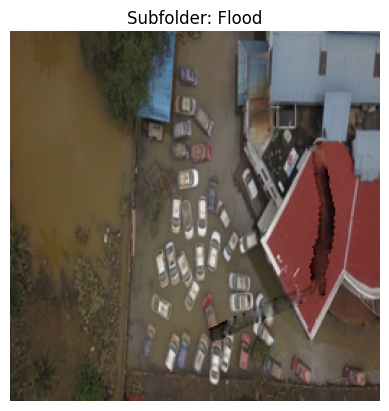

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

drive_path = '/content/drive/MyDrive/DL_Milestone_2/train_inpainted'

# Function to load PNG images from subfolders
def load_images_from_subfolders(folder_path):
    image_data = []
    subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]

    for subfolder in subfolders:
        subfolder_name = os.path.basename(subfolder)
        print(f"Loading images from {subfolder_name}...")

        for file_name in os.listdir(subfolder):
            if file_name.endswith('.png'):
                file_path = os.path.join(subfolder, file_name)
                img = Image.open(file_path)
                image_data.append((subfolder_name, img))

    return image_data

image_data = load_images_from_subfolders(drive_path)

## Display the first image from the loaded data
if image_data:
    subfolder_name, img = image_data[0]
    plt.imshow(img)
    plt.title(f"Subfolder: {subfolder_name}")
    plt.axis('off')
    plt.show()

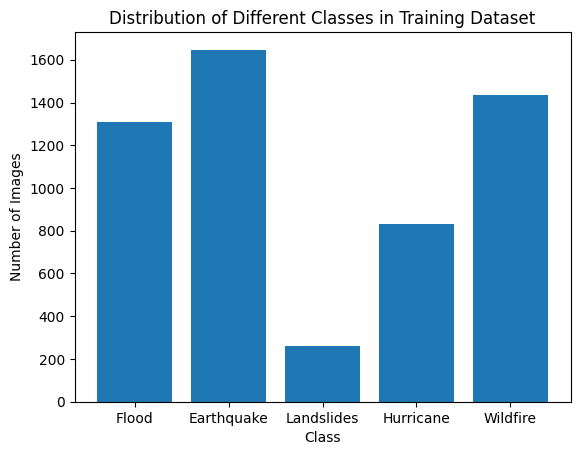

In [ ]:
# Get class distribution
class_distribution = Counter([class_name for class_name, _ in image_data])

# Plot the distribution
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title('Distribution of Different Classes in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

## Data Augmentation

In [ ]:
from PIL import Image, ImageFilter
import os
from tqdm import tqdm

def augment_images(input_dir, output_dir, classes_to_augment):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_name in classes_to_augment:
        class_dir = os.path.join(input_dir, class_name)
        output_class_dir = os.path.join(output_dir, class_name)

        if not os.path.exists(output_class_dir):
            os.makedirs(output_class_dir)

        for filename in tqdm(os.listdir(class_dir), desc=f"Processing {class_name} images"):
            image_path = os.path.join(class_dir, filename)

            # Mirroring
            mirrored_output_path = os.path.join(output_class_dir, f"mirrored_{filename}")
            mirror_image(image_path, mirrored_output_path)

            # Blurring
            blurred_output_path = os.path.join(output_class_dir, f"blurred_{filename}")
            blur_image(image_path, blurred_output_path)

    print("Data augmentation completed.")

def mirror_image(input_path, output_path):
    with Image.open(input_path) as img:
        # Mirror the image horizontally
        mirrored_img = img.transpose(Image.FLIP_LEFT_RIGHT)
        # Save the mirrored image
        mirrored_img.save(output_path)

def blur_image(input_path, output_path):
    with Image.open(input_path) as img:
        # Apply Gaussian blur to the image
        blurred_img = img.filter(ImageFilter.GaussianBlur(radius=2))
        # Save the blurred image
        blurred_img.save(output_path)


In [ ]:
input_dir = "/content/drive/MyDrive/DL_Milestone_2/train_inpainted"
output_dir = "/content/drive/MyDrive/DL_Milestone_2/train_augmented"
classes_to_augment = ["Landslides"]
augment_images(input_dir, output_dir, classes_to_augment)

Processing Landslides images: 100%|██████████| 260/260 [00:21<00:00, 12.14it/s]

Data augmentation completed.


In [ ]:
import os
import shutil

def shift_png_files(source_folder, destination_folder):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # List all files in the source folder
    files = os.listdir(source_folder)

    # Filter only PNG files
    png_files = [file for file in files if file.lower().endswith('.png')]

    # Move PNG files to the destination folder
    for png_file in png_files:
        source_path = os.path.join(source_folder, png_file)
        destination_path = os.path.join(destination_folder, png_file)

        shutil.move(source_path, destination_path)
        print(f"Moved {png_file} to {destination_folder}")

In [ ]:
import os
import shutil

def shift_png_files(source_folder, destination_folder):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # List all files in the source folder
    files = os.listdir(source_folder)

    # Filter only PNG files
    png_files = [file for file in files if file.lower().endswith('.png')]

    # Move PNG files to the destination folder
    for png_file in png_files:
        source_path = os.path.join(source_folder, png_file)
        destination_path = os.path.join(destination_folder, png_file)

        shutil.move(source_path, destination_path)
        print(f"Moved {png_file} to {destination_folder}")

In [ ]:
source_folder = "/content/drive/MyDrive/DL_Milestone_2/train_augmented/Landslides"
destination_folder = "/content/drive/MyDrive/DL_Milestone_2/train_inpainted/Landslides"
shift_png_files(source_folder, destination_folder)

Moved mirrored_Image_388.png to /content/drive/MyDrive/DL_Milestone_2/train_inpainted/Landslides
Moved blurred_Image_388.png to /content/drive/MyDrive/DL_Milestone_2/train_inpainted/Landslides
Moved mirrored_Image_235.png to /content/drive/MyDrive/DL_Milestone_2/train_inpainted/Landslides
Moved blurred_Image_235.png to /content/drive/MyDrive/DL_Milestone_2/train_inpainted/Landslides
Moved mirrored_Image_396.png to /content/drive/MyDrive/DL_Milestone_2/train_inpainted/Landslides
Moved blurred_Image_396.png to /content/drive/MyDrive/DL_Milestone_2/train_inpainted/Landslides
Moved mirrored_Image_104.png to /content/drive/MyDrive/DL_Milestone_2/train_inpainted/Landslides
Moved blurred_Image_104.png to /content/drive/MyDrive/DL_Milestone_2/train_inpainted/Landslides
Moved mirrored_Image_221.png to /content/drive/MyDrive/DL_Milestone_2/train_inpainted/Landslides
Moved blurred_Image_221.png to /content/drive/MyDrive/DL_Milestone_2/train_inpainted/Landslides
Moved mirrored_Image_291.png to /co

In [ ]:
drive_path = '/content/drive/MyDrive/DL_Milestone_2/train_inpainted'
image_data = load_images_from_subfolders(drive_path)

Loading images from Flood...
Loading images from Earthquake...
Loading images from Landslides...
Loading images from Hurricane...
Loading images from Wildfire...


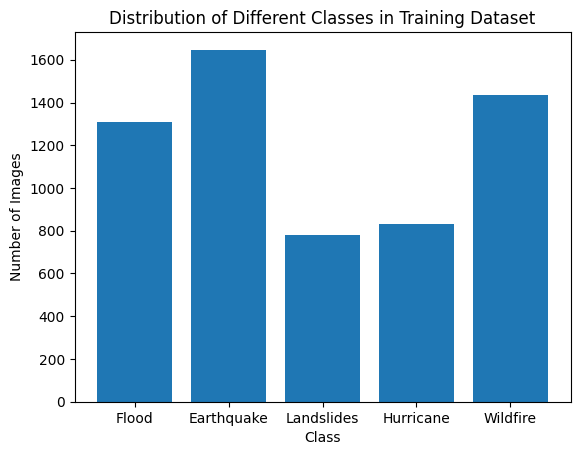

In [ ]:
# Get class distribution
class_distribution = Counter([class_name for class_name, _ in image_data])

# Plot the distribution
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title('Distribution of Different Classes in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

Loading images from Hurricane...
Loading images from Flood...
Loading images from Landslides...
Loading images from Wildfire...
Loading images from Earthquake...


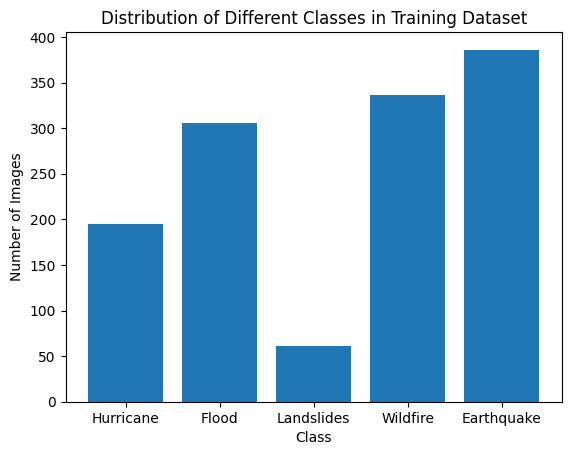

In [ ]:
validation_path = '/content/drive/MyDrive/DL_Milestone_2/validation_inpainted'
val_image_data = load_images_from_subfolders(validation_path)

# Get class distribution
class_distribution = Counter([class_name for class_name, _ in val_image_data])

# Plot the distribution
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title('Distribution of Different Classes in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

In [ ]:
#Data augmentation on validation set

input_dir = "/content/drive/MyDrive/DL_Milestone_2/validation_inpainted"
output_dir = "/content/drive/MyDrive/DL_Milestone_2/validation_augmented"
classes_to_augment = ["Landslides"]
augment_images(input_dir, output_dir, classes_to_augment)

#Shift augmented images to validation folder

source_folder = "/content/drive/MyDrive/DL_Milestone_2/validation_augmented/Landslides"
destination_folder = "/content/drive/MyDrive/DL_Milestone_2/validation_inpainted/Landslides"
shift_png_files(source_folder, destination_folder)

Processing Landslides images: 100%|██████████| 61/61 [00:05<00:00, 11.22it/s]


Data augmentation completed.
Moved mirrored_Image_403.png to /content/drive/MyDrive/DL_Milestone_2/validation_inpainted/Landslides
Moved blurred_Image_403.png to /content/drive/MyDrive/DL_Milestone_2/validation_inpainted/Landslides
Moved mirrored_Image_379.png to /content/drive/MyDrive/DL_Milestone_2/validation_inpainted/Landslides
Moved blurred_Image_379.png to /content/drive/MyDrive/DL_Milestone_2/validation_inpainted/Landslides
Moved mirrored_Image_204.png to /content/drive/MyDrive/DL_Milestone_2/validation_inpainted/Landslides
Moved blurred_Image_204.png to /content/drive/MyDrive/DL_Milestone_2/validation_inpainted/Landslides
Moved mirrored_Image_254.png to /content/drive/MyDrive/DL_Milestone_2/validation_inpainted/Landslides
Moved blurred_Image_254.png to /content/drive/MyDrive/DL_Milestone_2/validation_inpainted/Landslides
Moved mirrored_Image_91.png to /content/drive/MyDrive/DL_Milestone_2/validation_inpainted/Landslides
Moved blurred_Image_91.png to /content/drive/MyDrive/DL_Mi

Loading images from Hurricane...
Loading images from Flood...
Loading images from Landslides...
Loading images from Wildfire...
Loading images from Earthquake...


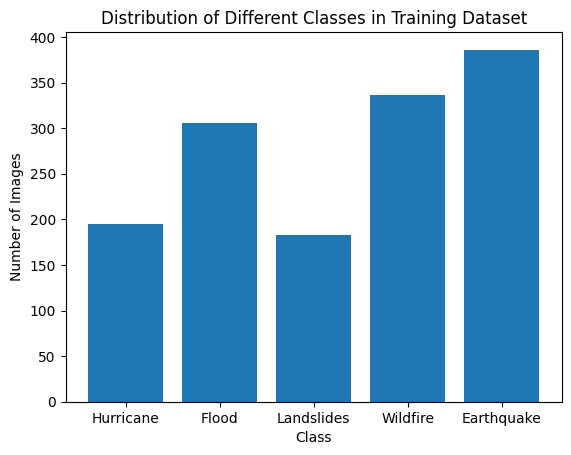

In [ ]:
validation_path = '/content/drive/MyDrive/DL_Milestone_2/validation_inpainted'
val_image_data = load_images_from_subfolders(validation_path)

# Get class distribution
class_distribution = Counter([class_name for class_name, _ in val_image_data])

# Plot the distribution
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title('Distribution of Different Classes in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

## Model Specifications

In [ ]:
import tensorflow as tf
from keras.metrics import Precision, Recall

d = tf.keras.applications.DenseNet121(include_top=False,
                   input_shape=(256,256,3),
                   pooling=None,
                   weights='imagenet')
for i in d.layers:
  i.trainable = True

output_avg = tf.keras.layers.GlobalAveragePooling2D()(d.output)
output_max = tf.keras.layers.GlobalMaxPooling2D()(d.output)
m = tf.keras.layers.minimum([output_avg, output_max])
m = tf.keras.layers.Dropout(0.5)(m)
m = tf.keras.layers.Dense(128, activation = "sigmoid")(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(256, activation = "relu")(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(512, activation = "relu")(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(5, activation= "softmax")(m)
m = tf.keras.models.Model(inputs = d.input, outputs = m)
m.compile(optimizer = tf.keras.optimizers.Adam(0.0001),
          loss = "categorical_crossentropy",
          metrics =["accuracy", Precision(name='precision'), Recall(name='recall')])
#m.summary()

29084464/29084464 [==============================] - 0s 0us/step


## Model Training

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

drive_path = '/content/drive/MyDrive/DL_Milestone_2/train_inpainted'

train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(drive_path, batch_size=16, class_mode='categorical', target_size=(256, 256), shuffle=True)

validation_path = '/content/drive/MyDrive/DL_Milestone_2/validation_inpainted'

validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow_from_directory(validation_path, batch_size=16, class_mode='categorical', target_size=(256, 256), shuffle=True)

Found 6003 images belonging to 5 classes.
Found 1406 images belonging to 5 classes.


In [ ]:
callbacks = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
best_model_file = '/content/drive/MyDrive/DL_Milestone_2/model_2'
best_model = ModelCheckpoint(best_model_file, monitor='val_accuracy', verbose = 1, save_best_only = True)

In [ ]:
history = m.fit(train_generator, epochs=30, verbose=1, validation_data=validation_generator, callbacks = [callbacks, best_model])

Epoch 1/30
376/376 [==============================] - ETA: 0s - loss: 0.8811 - accuracy: 0.6747 - precision: 0.8662 - recall: 0.4928
Epoch 1: val_accuracy improved from -inf to 0.54054, saving model to /content/drive/MyDrive/DL_Milestone_2/model_2
376/376 [==============================] - 2705s 7s/step - loss: 0.8811 - accuracy: 0.6747 - precision: 0.8662 - recall: 0.4928 - val_loss: 2.0746 - val_accuracy: 0.5405 - val_precision: 0.5418 - val_recall: 0.5349
Epoch 2/30
376/376 [==============================] - ETA: 0s - loss: 0.3147 - accuracy: 0.9032 - precision: 0.9200 - recall: 0.8846
Epoch 2: val_accuracy improved from 0.54054 to 0.85277, saving model to /content/drive/MyDrive/DL_Milestone_2/model_2
376/376 [==============================] - 189s 503ms/step - loss: 0.3147 - accuracy: 0.9032 - precision: 0.9200 - recall: 0.8846 - val_loss: 0.4326 - val_accuracy: 0.8528 - val_precision: 0.8612 - val_recall: 0.8514
Epoch 3/30
376/376 [==============================] - ETA: 0s - loss:

In [ ]:
m.save_weights('/content/drive/MyDrive/DL_Milestone_2/model_weights.h5')

### Loss Function of Training

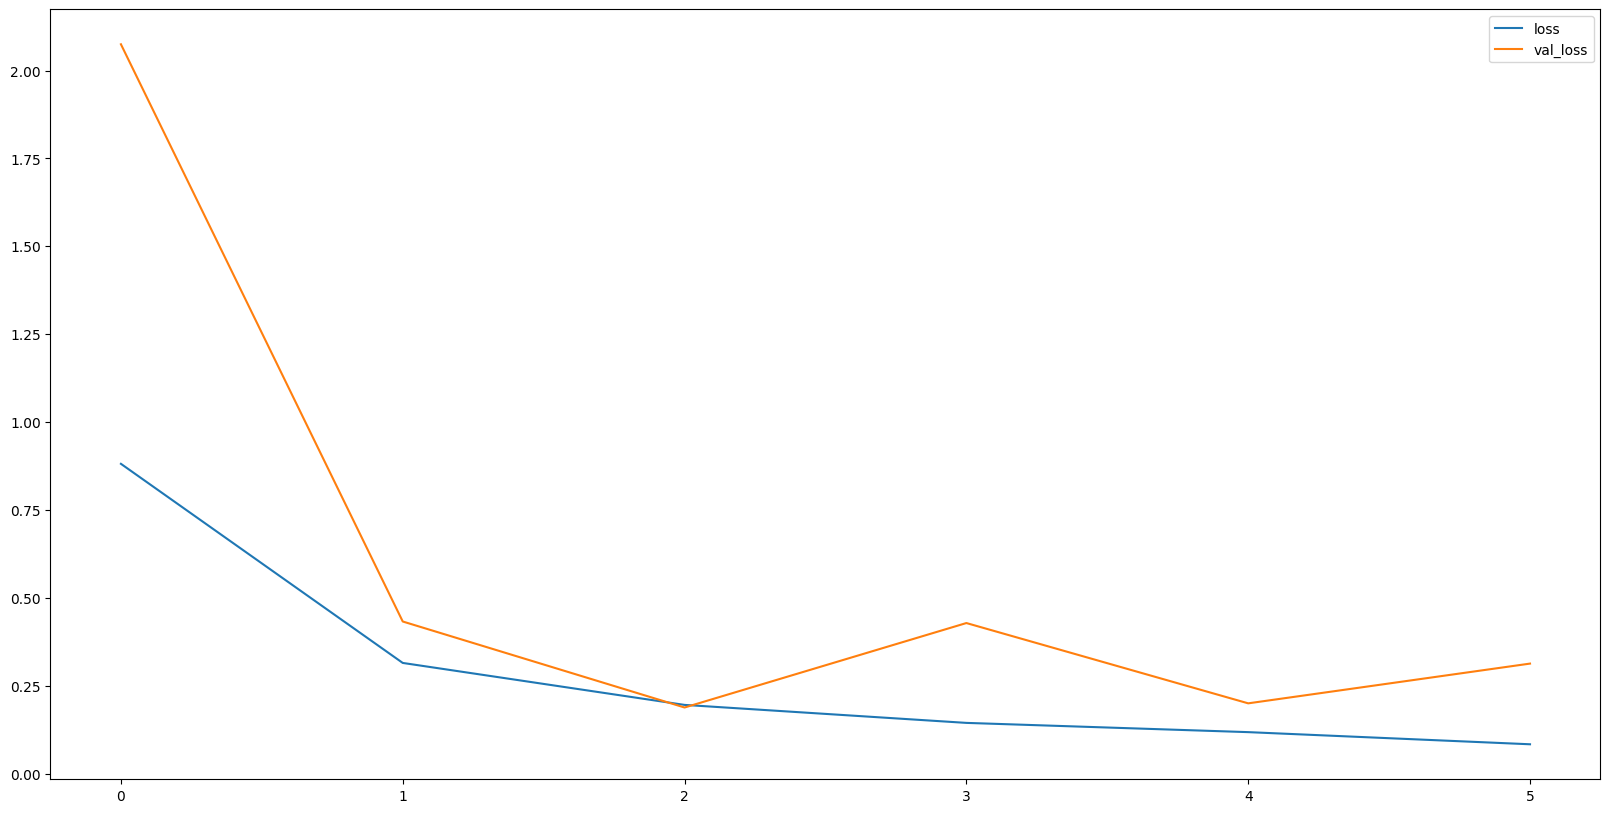

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 10))
plt.plot(history.history['loss'], label = "loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend()

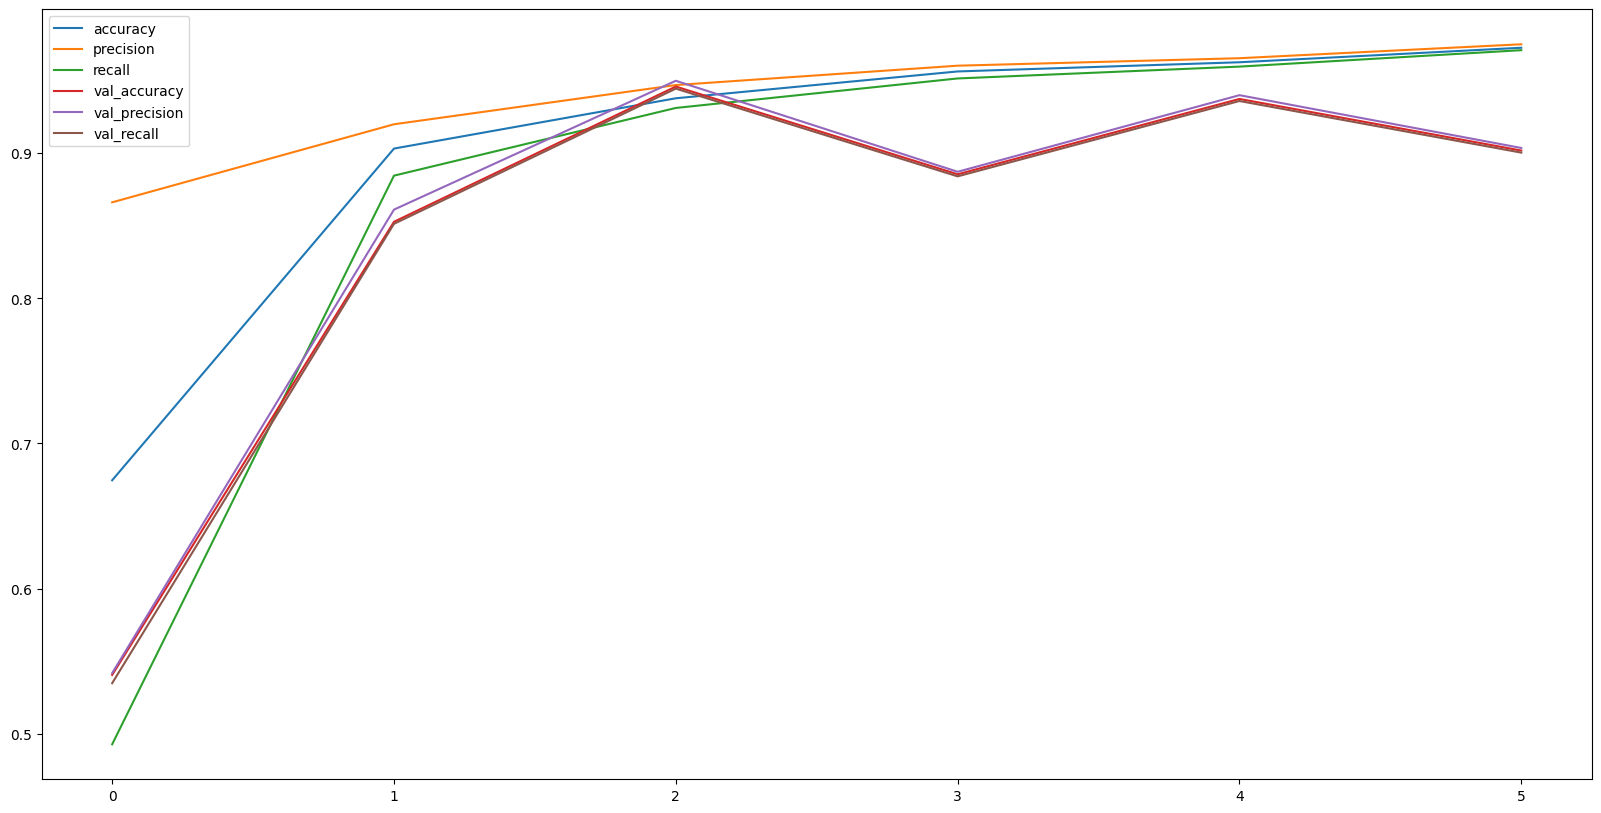

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 10))
plt.plot(history.history['accuracy'], label = "accuracy")
plt.plot(history.history['precision'], label = "precision")
plt.plot(history.history['recall'], label = "recall")
plt.plot(history.history['val_accuracy'], label = "val_accuracy")
plt.plot(history.history['val_precision'], label = "val_precision")
plt.plot(history.history['val_recall'], label = "val_recall")
plt.legend()

## Model Testing

### Model Testing for Validation Data

Found 1406 images belonging to 5 classes.
88/88 [==============================] - 11s 99ms/step - loss: 0.1879 - accuracy: 0.9459 - precision: 0.9499 - recall: 0.9445
Test Loss: 0.1879
Test Accuracy: 0.9459
Test Precision: 0.9499
Test Recall: 0.9445
88/88 [==============================] - 14s 127ms/step
Confusion Matrix:
[[370   3  11   2   0]
 [  5 282  11   8   0]
 [  5   7 177   5   1]
 [  0   0   0 183   0]
 [  6   2   5   5 318]]


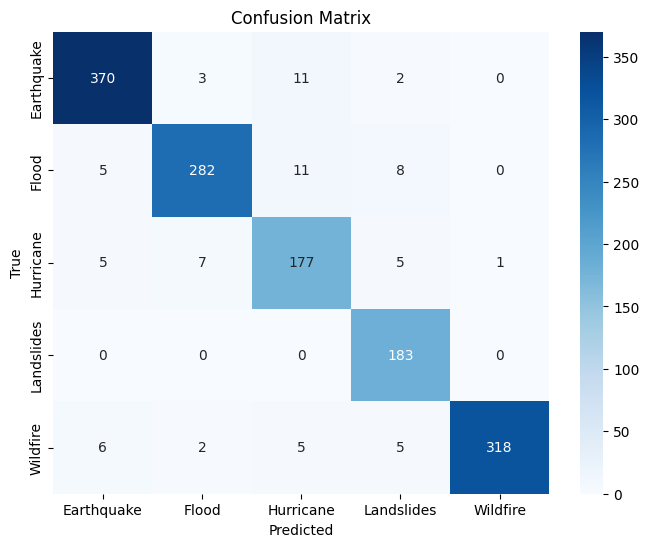


Classification Report:
              precision    recall  f1-score   support

  Earthquake       0.96      0.96      0.96       386
       Flood       0.96      0.92      0.94       306
   Hurricane       0.87      0.91      0.89       195
  Landslides       0.90      1.00      0.95       183
    Wildfire       1.00      0.95      0.97       336

    accuracy                           0.95      1406
   macro avg       0.94      0.95      0.94      1406
weighted avg       0.95      0.95      0.95      1406



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras.metrics import Precision, Recall

# Load the trained model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/DL_Milestone_2/model_2')
test_path = '/content/drive/MyDrive/DL_Milestone_2/validation_inpainted'
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(test_path, batch_size=16, class_mode='categorical', target_size=(256, 256), shuffle=False)

# Evaluate the model on the test data
test_loss, test_accuracy, test_precision, test_recall = loaded_model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')

# Read labels of test class
true_labels = test_generator.classes

# Generate predictions
predicted_probabilities = loaded_model.predict(test_generator)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
class_labels = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

### Model Testing for Train Data

Found 6003 images belonging to 5 classes.
376/376 [==============================] - 60s 153ms/step - loss: 0.0739 - accuracy: 0.9757 - precision: 0.9779 - recall: 0.9737
Test Loss: 0.0739
Test Accuracy: 0.9757
Test Precision: 0.9779
Test Recall: 0.9737
376/376 [==============================] - 41s 102ms/step
Confusion Matrix:
[[1600    2   36    8    1]
 [   8 1259   33    8    2]
 [   6    4  810   12    0]
 [   0    0    0  778    2]
 [   6    0    9    9 1410]]


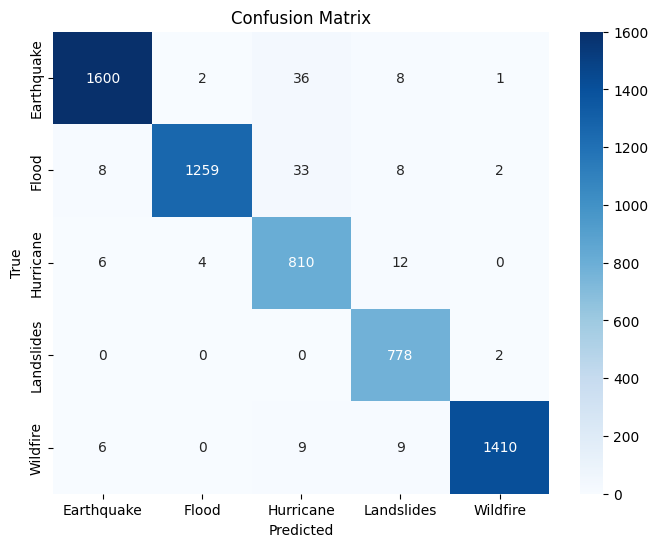


Classification Report:
              precision    recall  f1-score   support

  Earthquake       0.99      0.97      0.98      1647
       Flood       1.00      0.96      0.98      1310
   Hurricane       0.91      0.97      0.94       832
  Landslides       0.95      1.00      0.98       780
    Wildfire       1.00      0.98      0.99      1434

    accuracy                           0.98      6003
   macro avg       0.97      0.98      0.97      6003
weighted avg       0.98      0.98      0.98      6003



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras.metrics import Precision, Recall

# Load the trained model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/DL_Milestone_2/model_2')
test_path = '/content/drive/MyDrive/DL_Milestone_2/train_inpainted'
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(test_path, batch_size=16, class_mode='categorical', target_size=(256, 256), shuffle=False)

# Evaluate the model on the test data
test_loss, test_accuracy, test_precision, test_recall = loaded_model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')

# Read labels of test class
true_labels = test_generator.classes

# Generate predictions
predicted_probabilities = loaded_model.predict(test_generator)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
class_labels = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

# **Evaluate Block**

Run the two code blocks below after making the required changes to addresses as per the comments given below.

### **Read Me**
 We were unable to write a method that could take torch tensors as inputs as the model uses images in numpy format. We tried using the .numpy() method however that led to the RAM space being completely used up for some reason. However, any batch of data stored in the folder given as corrupted_images_address seperated into subfolders can be given as input and this evaluate bloack would do the needful and print the given metrics as well.

In [ ]:
# Write the address of folder containing paired test images in corrupted_images_address
corrupted_images_address = "Test"

# Write the address of folder containing actual test images in actual_images_address
# These images are required to calculate the SSIM and PSNR values
actual_images_address = "Test_Actual"

# Write the address of folder where you want inpainted images to be stored.
file_out_address = "Test_Inpainted"

# All three folders mentioned above must have images contained in subfolders named as their class names.
# You can move the test_inpainted folder in our drive to the your desired location.

# Write the GAN model path address here
model_path = "/content/drive/MyDrive/DL_Milestone_2/output/model_new/latest_checkpoint"
# Write the CNN model path address here
model_path_2 = '/content/drive/MyDrive/DL_Milestone_2/model_2'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

import tensorflow as tf
import cv2 as cv
import random
import os
import math
import numpy as np

def random_interpolates(x, y, alpha=None):
    """
    x: first dimension as batch_size
    y: first dimension as batch_size
    alpha: [BATCH_SIZE, 1]
    """
    shape = x.get_shape().as_list()
    x = tf.reshape(x, [shape[0], -1])
    y = tf.reshape(y, [shape[0], -1])
    if alpha is None:
        alpha = tf.compat.v1.random_uniform(shape=[shape[0], 1])
    interpolates = x + alpha*(y - x)
    return tf.reshape(interpolates, shape)


def gradients_penalty(x, y, mask=None, norm=1.):
    """Improved Training of Wasserstein GANs
    - https://arxiv.org/abs/1704.00028
    """
    gradients = tf.gradients(y, x)[0]
    if mask is None:
        mask = tf.ones_like(gradients)
    slopes = tf.sqrt(tf.reduce_mean(tf.square(gradients) * mask, axis=[1, 2, 3]))
    return tf.reduce_mean(tf.square(slopes - norm))


def standard_conv(x,mask,cnum,ksize=3,stride=1,rate=1,name='conv',padding='SAME'):
        '''
        define convolution for generator
        Args:
                x:iput image
                cnum: channel number
                ksize: kernal size
                stride: convolution stride
                rate : rate for dilated conv
                name: name of layers
        '''
        p       = int(rate*(ksize-1)/2)
        x       = tf.pad(x, [[0,0], [p, p], [p, p], [0,0]],'REFLECT')
        padding = 'VALID'
        x       = tf.compat.v1.layers.conv2d(x,cnum,ksize,stride,dilation_rate=rate,activation=tf.nn.elu
                                  ,padding=padding,name=name+'_1')
        return x
def standard_dconv(x,mask,cnum,name='deconv',padding='VALID'):
        '''
        define upsample convolution for generator
        Args:
        x: input image
        mask: input mask
        name: name of layers
        '''
        rate   = 1
        ksize  = 3
        stride = 1
        shape  = x.get_shape().as_list()
        x      = tf.compat.v1.image.resize_nearest_neighbor(x,[shape[1]*2,shape[2]*2])
        p3     = int(1 * (3 - 1) / 2)
        x      = tf.pad(x, [[0,0], [p3,p3], [p3,p3], [0,0]], 'REFLECT')
        x      = tf.compat.v1.layers.conv2d(x,cnum,ksize,stride,dilation_rate=rate,activation=tf.nn.elu
                                          ,padding=padding,name=name+'_1')
        return x


def l2_norm(v, eps=1e-12):
    return v / (tf.reduce_sum(v ** 2) ** 0.5 + eps)


def spectral_norm(w, iteration=1,name='dasd'):
   w_shape = w.shape.as_list()
   w = tf.reshape(w, [-1, w_shape[-1]])

   u = tf.compat.v1.get_variable(name+"u", [1, w_shape[-1]], initializer=tf.compat.v1.truncated_normal_initializer(), trainable=False)

   u_hat = u
   v_hat = None
   for i in range(0, iteration):
       v_ = tf.matmul(u_hat, tf.transpose(w))
       v_hat = l2_norm(v_)

       u_ = tf.matmul(v_hat, w)
       u_hat = l2_norm(u_)

   sigma = tf.matmul(tf.matmul(v_hat, w), tf.transpose(u_hat))
   w_norm = w / sigma

   with tf.control_dependencies([u.assign(u_hat)]):
       w_norm = tf.reshape(w_norm, w_shape)

   return w_norm


def LeakyRelu(x, leak=0.2, name="LeakyRelu"):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * tf.abs(x)


def dis_conv(x, cnum, ksize=5, stride=2, activation = 'leak_relu', name='conv'):
    """
    covolution for discriminator.
    Args:
        x: input image
        cnum: channel number.
        ksize: kernel size.
        Stride: convolution stride.
        name: name of layers.
    """

    x_shape = x.get_shape().as_list()
    w = tf.compat.v1.get_variable(name = name+'_w',shape = [ksize, ksize, x_shape[-1]] + [cnum])
    w = spectral_norm(w, name = name)
    x = tf.nn.conv2d(x, w, strides = [1, stride, stride, 1], padding = 'SAME')
    bias = tf.compat.v1.get_variable(name=name+'_bias',shape=[cnum])
    if activation != None:
        return  LeakyRelu(x + bias, name = name)
    else:
        return x + bias

from random import randint
import itertools
import numpy as np
import cv2
from math import *
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

def continuous_mask(height, width,num,maxAngle,maxLength,maxBrushWidth,channels=3):
    """Generates a continuous mask with lines, circles and elipses"""

    img = np.zeros((height, width, channels), np.uint8)

    for j in range(0, 1):
        startX = randint(0, width)
        startY = randint(0, height)
        for i in range(0,randint(1,num)):
            angle = randint(0,maxAngle)
            if i%2==0:
                angle = 360 - angle
            length = randint(1,maxLength)
            brushWidth = randint(1, maxBrushWidth)
            endX   = startX + int(length * sin(angle))
            endY   = startY + int(length * cos(angle))
            if endX>255:
                endX = 255
            if endX<0:
                endX = 0
            if endY>255:
                endY = 255
            if endY<0:
                endY = 0
            cv2.line(img, (startX,startY),(endX,endY),(255,255,255),brushWidth)
            cv2.circle(img, (endX,endY),brushWidth//2,(255,255,255),-1)
            startY = endY
            startX = endX


    img2 = np.zeros((height, width,1))
    img2[:, :,0] = img[:, :, 0]
    img2[img2>1] = 1

    return 1-img2



def discontinuous_mask(height, width,num,low,high,channels=3):
    """Generates a discontinuous mask with lines, circles and elipses
       When we were training, we generated more elipses
    """
    img = np.zeros((height, width, channels), np.uint8)

    # Set size scale
    size = int((width + height) * 0.1)
    if width < 64 or height < 64:
        raise Exception("Width and Height of mask must be at least 64!")

    # Draw random lines
    for _ in range(0, randint(1, num)):
        x1, x2 = randint(1, width), randint(1, width)
        y1, y2 = randint(1, height), randint(1, height)
        thickness = randint(3, size)
        cv2.line(img,(x1,y1),(x2,y2),(1,1,1),thickness)

    # Draw random circles
    for _ in range(0, randint(1, num)):
        x1, y1 = randint(1, width), randint(1, height)
        radius = randint(3, size)
        cv2.circle(img,(x1,y1),radius,(1,1,1), -1)

    # Draw randow rectangle
    for _ in range(0, randint(1, num)):
        x1,y1 = randint(1, width), randint(1, height)
        x2,y2 = randint(1, width), randint(1, height)
        cv2.rectangle(img, (x1, y1), (x2, y2), (1, 1, 1), -1)

    # Draw random ellipses
    for _ in range(0, randint(1, num)):
        x1, y1 = randint(1, width), randint(1, height)
        s1, s2 = randint(low, high), randint(low, high)
        a1, a2, a3 = randint(3, 180), randint(3, 180), randint(3, 180)
        thickness = randint(3, size)
        cv2.ellipse(img, (x1,y1), (s1,s2), a1, a2, a3,(1,1,1), thickness)

    img2 = np.zeros((height, width,1))
    img2[:, :,0] = img[:, :, 0]
    img2[img2>1] = 1

    return img2

import tensorflow as tf
import cv2 as cv
import numpy as np

def region_deconv(x_complete, x_missing, mask,name = 'com_'):
    shape = x_complete.get_shape().as_list()
    mask = tf.compat.v1.image.resize_nearest_neighbor(mask, size = [shape[1], shape[2]], align_corners=True)
    mask = tf.reshape(mask, [shape[0], shape[1], shape[2], 1])
    x_complete = x_complete * mask
    shape = x_missing.get_shape().as_list()
    x_missing  = x_missing  * (1 - mask)
    x_fusion   = tf.concat([x_complete,x_missing], axis = -1)

    x_fusion   = standard_dconv(x_fusion,mask,shape[-1],name = name+"_fusion")
    return x_fusion

def region_conv(x_complete, x_missing, mask,name = 'com_'):
    shape = x_complete.get_shape().as_list()
    mask = tf.compat.v1.image.resize_nearest_neighbor(mask, size = [shape[1], shape[2]], align_corners=True)
    mask = tf.reshape(mask, [shape[0], shape[1], shape[2], 1])
    p3 = int(1 * (3 - 1) / 2)

    x_complete = x_complete * mask
    shape = x_missing.get_shape().as_list()
    x_missing  = x_missing  * (1 - mask)
    x_fusion   = tf.concat([x_complete,x_missing], axis = -1)
    x_fusion   = tf.pad(x_fusion, [[0,0], [p3,p3], [p3,p3], [0,0]], 'REFLECT')

    x_fusion   = tf.compat.v1.layers.conv2d(x_fusion, shape[-1], kernel_size = 3, strides = 1, padding = 'VALID', dilation_rate = 1, name = name + "_fusion")
    x_fusion   = tf.nn.elu(x_fusion)
    return x_fusion

import inspect
import os

import numpy as np
import tensorflow as tf
import time

VGG_MEAN = [103.939, 116.779, 123.68]


class Vgg16:
    def __init__(self, vgg16_npy_path=None):
        if vgg16_npy_path is None:
            path = inspect.getfile(Vgg16)
            path = os.path.abspath(os.path.join(path, os.pardir))
            path = os.path.join(path, "vgg16.npy")
            vgg16_npy_path = path
            print(path)

        self.data_dict = np.load(vgg16_npy_path, encoding='latin1', allow_pickle=True).item()
        print("npy file loaded")

    def build(self, rgb):
        """
        load variable from npy to build the VGG
        :param rgb: rgb image [batch, height, width, 3] values scaled [0, 1]
        """

        start_time = time.time()
        rgb = tf.compat.v1.image.resize_images(rgb, (224, 224))
        print("build model started")
        rgb_scaled = (rgb+1.) * 127.5
        #print(type(rgb[0][0][0][0]))

        # Convert RGB to BGR
        # red, green, blue = tf.split(3, 3, rgb_scaled)
        red, green, blue = tf.split(rgb_scaled, 3, 3)
        assert red.get_shape().as_list()[1:] == [224, 224, 1]
        assert green.get_shape().as_list()[1:] == [224, 224, 1]
        assert blue.get_shape().as_list()[1:] == [224, 224, 1]
        bgr = tf.concat([
            blue - VGG_MEAN[0],
            green - VGG_MEAN[1],
            red - VGG_MEAN[2],
        ], 3)
        assert bgr.get_shape().as_list()[1:] == [224, 224, 3]

        self.conv1_1 = self.conv_layer(bgr, "conv1_1")
        self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
        self.pool1 = self.max_pool(self.conv1_2, 'pool1')

        self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
        self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
        self.pool2 = self.max_pool(self.conv2_2, 'pool2')

        self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
        self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
        self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
        self.pool3 = self.max_pool(self.conv3_3, 'pool3')

        self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
        self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
        self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")
        self.pool4 = self.max_pool(self.conv4_3, 'pool4')

        self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
        self.conv5_2 = self.conv_layer(self.conv5_1, "conv5_2")
        self.conv5_3 = self.conv_layer(self.conv5_2, "conv5_3")
        self.pool5 = self.max_pool(self.conv5_3, 'pool5')


        print("build model finished: %ds" % (time.time() - start_time))

    def avg_pool(self, bottom, name):
        return tf.nn.avg_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def max_pool(self, bottom, name):
        return tf.nn.max_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def conv_layer(self, bottom, name):
        with tf.compat.v1.variable_scope(name):
            filt = self.get_conv_filter(name)

            conv = tf.nn.conv2d(bottom, filt, [1, 1, 1, 1], padding='SAME')

            conv_biases = self.get_bias(name)
            bias = tf.nn.bias_add(conv, conv_biases)

            relu = tf.nn.relu(bias)
            return relu

    def fc_layer(self, bottom, name):
        with tf.compat.v1.variable_scope(name):
            shape = bottom.get_shape().as_list()
            dim = 1
            for d in shape[1:]:
                dim *= d
            x = tf.reshape(bottom, [-1, dim])

            weights = self.get_fc_weight(name)
            biases = self.get_bias(name)

            # Fully connected layer. Note that the '+' operation automatically
            # broadcasts the biases.
            fc = tf.nn.bias_add(tf.matmul(x, weights), biases)

            return fc

    def get_conv_filter(self, name):
        return tf.constant(self.data_dict[name][0], name="filter")

    def get_bias(self, name):
        return tf.constant(self.data_dict[name][1], name="biases")

    def get_fc_weight(self, name):
        return tf.constant(self.data_dict[name][0], name="weights")

def loss_perceptual(pic1, pic2, pic3):
    loss = 0

    for o, c, g in zip(pic2, pic3, pic1):
        loss += l1(o, g) + l1(c, g)
    return loss

def l1(pic1, pic2):
    return tf.reduce_sum(tf.abs(pic1 - pic2))

def gram_matrix(x):
    shape = tf.shape(x)
    B, H, W, C = shape[0], shape[1], shape[2], shape[3]
    features = tf.reshape(x, tf.stack([B, -1, C]))
    gram = tf.matmul(features, features, transpose_a=True)
    gram = gram / tf.cast(C * H * W, x.dtype)
    return gram
def new_gram(x):
    shape = tf.shape(x)
    B, H, W, C = shape[0], shape[1], shape[2], shape[3]
    features = tf.reshape(x, tf.stack([B, -1, C]))
    gram = tf.matmul(features, features, transpose_b=True)
    gram = gram / tf.cast(C * C, x.dtype)
    return gram
def loss_style(output, vgg_gt):
    loss = 0
    for o, g in zip(output, vgg_gt):
        loss += l1(gram_matrix(o), gram_matrix(g))
    return loss

def loss_cor(output, vgg_gt):
    loss = 0
    loss_new = l1(new_gram(output[1]), new_gram(vgg_gt[1]))
    return loss_new

import tensorflow as tf
import cv2 as cv
import numpy as np

def RW_generator(x,mask,padding='SAME',name='inpaint_net',reuse=False):
    '''
    Region-wise generator
    Args:
            x: incomplete image
            mask: mask region {0,1}
    returns:
            predicted image
    '''
    x1 = SINet(x, mask, reuse=reuse)
    x_combine = x * mask + x1 * (1 - mask)
    x2 = GPNet(x_combine,mask, reuse=reuse)
    return x1, x2

def SINet(x,mask,padding='SAME',name='inpaint_net',reuse=False):
    '''
    Semantic inferring network
    Args:
            x: incomplete image
            mask: mask region {0,1}
    returns:
            image predicted by semantic inferring network
    '''
    xin=x;
    mask_in=mask
    cnum=32
    ones_x = tf.ones_like(x)[:, :, :, 0:1]
    x = tf.concat([x, mask], axis=3)
    with tf.compat.v1.variable_scope(name,reuse=reuse):
            x1=standard_conv(x,mask,cnum,5,1,name='conv1')
            x2=standard_conv(x1,mask,2*cnum,3,2,name='conv2_downsample')
            x3=standard_conv(x2,mask,2*cnum,3,1,name='conv3')
            x4=standard_conv(x3,mask,4*cnum,3,2,name='conv4_downsample')
            x5=standard_conv(x4,mask,4*cnum,3,1,name='conv5')
            x6=standard_conv(x5,mask,4*cnum,3,1,name='conv6')

            #dilated conv
            x7=standard_conv(x6,mask,4*cnum,3,rate=2,name='conv7_atrous')
            x8=standard_conv(x7,mask,4*cnum,3,rate=4,name='conv8_atrous')
            x9=standard_conv(x8,mask,4*cnum,3,rate=8,name='conv9_atrous')
            x10=standard_conv(x9,mask,4*cnum,3,rate=16,name='conv10_atrous')



            x11=standard_conv(tf.concat([x10,x6],axis=-1), mask,4*cnum,3,1,name='conv11')
            x12=standard_conv(tf.concat([x11,x5],axis=-1),mask,4*cnum,3,1,name='conv12')

            x_complete, x_missing = tf.concat([x12,x4],axis=-1),x12
            x13 = region_deconv(x_complete, x_missing, mask,name = 'com_13')

            x_complete, x_missing = tf.concat([x13,x3],axis=-1),x13
            x14 = region_conv(x_complete,x_missing,mask,name='com_14')

            x_complete, x_missing = tf.concat([x14,x2],axis=-1),x14
            x15 = region_deconv(x_complete, x_missing, mask, name = 'com_15')

            x16 = standard_conv(x15,mask,cnum,3,1,name='conv16')

            x17=standard_conv(x16,mask,cnum//2,3,1,name='conv17')
            x18=standard_conv(x17,mask,3,3,1,name='conv18')
            x18=tf.clip_by_value(x18,-1.,1.)

            return x18
def GPNet(x,mask,padding='SAME',name='inpaint_net_1',reuse=False):
    '''
    Global perceiving network
    Args:
            x: incomplete image
            mask: mask region {0,1}
    returns:
            image predicted by global perceiving network
    '''
    xin=x;
    mask_in=mask
    cnum=32
    x = tf.concat([x, mask], axis=3) #concat
    with tf.compat.v1.variable_scope(name,reuse=reuse):
            x1=standard_conv(x,mask,cnum,5,1,name='conv1')
            x2=standard_conv(x1,mask,2*cnum,3,2,name='conv2_downsample')
            x3=standard_conv(x2,mask,2*cnum,3,1,name='conv3')
            x4=standard_conv(x3,mask,4*cnum,3,2,name='conv4_downsample')
            x5=standard_conv(x4,mask,4*cnum,3,1,name='conv5')
            x6=standard_conv(x5,mask,4*cnum,3,1,name='conv6')

            #dilated conv
            x7=standard_conv(x6,mask,4*cnum,3,rate=2,name='conv7_atrous')
            x8=standard_conv(x7,mask,4*cnum,3,rate=4,name='conv8_atrous')
            x9=standard_conv(x8,mask,4*cnum,3,rate=8,name='conv9_atrous')
            x10=standard_conv(x9,mask,4*cnum,3,rate=16,name='conv10_atrous')



            x11=standard_conv(tf.concat([x10,x6],axis=-1), mask,4*cnum,3,1,name='conv11')
            x12=standard_conv(tf.concat([x11,x5],axis=-1),mask,4*cnum,3,1,name='conv12')

            x13=standard_dconv(tf.concat([x12,x4],axis=-1),mask,2*cnum,name='conv13_upsample')
            x14=standard_conv(tf.concat([x13,x3],axis=-1),mask,2*cnum,3,1,name='conv14')
            x15=standard_dconv(tf.concat([x14,x2],axis=-1),mask,cnum,name='conv15_upsample')
            x16=standard_conv(tf.concat([x15,x1],axis=-1),mask,cnum//2,3,1,name='conv16')
            x17=standard_conv(x16,mask,3,3,1,name='conv17')
            x18=tf.clip_by_value(x17,-1.,1.)

            return x18

def RW_discriminator(x, mask, batch_size, activation = 'leaky_relu',reuse=False):
    '''
    Region-wise discriminator
    Args:
            x: input images
            mask: mask region {0,1}
    returns:
            matrix {real, fake}
    '''
    with tf.compat.v1.variable_scope('discriminator',reuse=reuse):
            cnum=64
            x=tf.concat([x,mask],axis=3)
            x=dis_conv(x,cnum,name='d_conv1')
            x=dis_conv(x,2*cnum,name='d_conv2')
            x=dis_conv(x,4*cnum,name='d_conv3')
            x=dis_conv(x,4*cnum,name='d_conv4')
            x=dis_conv(x,4*cnum,name='d_conv5')
            x=dis_conv(x,4*cnum,name='d_conv6', activation = activation)
            return x
def build_graph_with_loss(batch_data, batch_size, mask, vgg_path, adv_type, stage = 0,
                         lambda_style = 0.001, lambda_cor = 0.00001, alpha = 0.01 ,lambda_adv = 1.0,
                         reuse=False, training = True):

    image_gt=tf.subtract(tf.divide(batch_data,127.5),1.)
    date_shape=batch_data.get_shape().as_list()
    batch_incomplete=image_gt*mask

    image_p1, image_p2 = RW_generator(batch_incomplete, mask)
    image_c1 = image_p1 * (1 - mask) + image_gt * mask
    image_c2 = image_p2 * (1 - mask) + image_gt * mask
    rec_loss = tf.reduce_sum(tf.abs(image_gt - image_p1)) + tf.reduce_sum(tf.abs(image_gt - image_p2))

    vgg = Vgg16(vgg_path)
    vgg.build(image_gt)
    vgg_pos = [vgg.pool1,vgg.pool2, vgg.pool3]
    vgg.build(image_c1)
    vgg_x1 =  [vgg.pool1,vgg.pool2, vgg.pool3]
    vgg.build(image_c2)
    vgg_x2 =  [vgg.pool1,vgg.pool2, vgg.pool3]

    cor_loss = loss_cor(vgg_x1, vgg_pos)
    style_loss= loss_style(vgg_x2, vgg_pos)
    cor_loss = cor_loss * lambda_cor
    style_loss = style_loss * lambda_style
    cor_style = cor_loss + style_loss


    if stage == 1:
        activation = None
        if adv_type == ' ':
            activation = 'leaky_relu'
        d_pred = RW_discriminator(image_c1 * (1 - mask), mask, batch_size, activation)
        d_pred2 = RW_discriminator(image_c2 * (1 - mask), mask, batch_size, activation, reuse = True)
        d_real = RW_discriminator(image_gt * (1 - mask), mask, batch_size, activation, reuse = True)
        mask_label = 1 - mask
        shape = d_pred.get_shape().as_list()
        mask_label =  tf.compat.v1.image.resize_nearest_neighbor(mask_label, [shape[1],shape[2]])
        if adv_type == 'wgan':
            penalty_img = random_interpolates(image_gt, image_c2)
            dout_penalty = RW_discriminator(penalty_img, mask, batch_size, activation,reuse = True)
            penalty_loss = gradients_penalty(penalty_img, dout_penalty, mask = mask)
            adv_d_loss =  tf.reduce_mean(d_pred * mask_label) + tf.reduce_mean(d_pred2 * mask_label) - 0.01 * tf.reduce_mean(d_real * mask_label) +penalty_loss
            adv_g_loss = -1 * tf.reduce_mean(d_pred * mask_label) - tf.reduce_mean(d_pred2 * mask_label)

        elif adv_type == 'gan':
            adv_d_loss = 0.01 * tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real, labels=tf.ones_like(d_real)) * mask_label) + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_pred, labels=tf.zeros_like(d_pred)) * mask_label) + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_pred2, labels=tf.zeros_like(d_pred2))* mask_label)
            adv_g_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_pred, labels=tf.ones_like(d_real)) * mask_label)  + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_pred2, labels=tf.ones_like(d_real)) * mask_label)

        elif adv_type == 'hinge':

            adv_d_loss =  0.01 * tf.reduce_mean(tf.nn.relu(1 - d_real) * mask_label) + tf.reduce_mean(tf.nn.relu(1 + d_pred) * mask_label)
            + tf.reduce_mean(tf.nn.relu(1 + d_pred2) * mask_label)
            adv_g_loss = -1 * tf.reduce_mean(tf.nn.relu(d_pred) * mask_label) - tf.reduce_mean(tf.nn.relu(d_pred2) * mask_label)
        else:

            adv_d_loss =  alpha*tf.reduce_sum(tf.abs(mask_label - d_real)) + tf.reduce_sum(tf.abs(0 - d_pred)) + tf.reduce_sum(tf.abs(0 - d_pred2))
            adv_g_loss = tf.reduce_sum(tf.abs(mask_label - d_pred)) + tf.reduce_sum(tf.abs(mask_label - d_pred2))
    else:
        adv_d_loss = None
        adv_g_loss = None

    if stage == 1:
        g_loss= rec_loss+cor_style + lambda_adv * adv_g_loss
    else:
        g_loss = rec_loss + cor_style
    g_vars=tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES,'inpaint_net')
    d_vars=tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES,'discriminator') if stage == 1 else None

    tf.compat.v1.summary.image('incomplete',batch_incomplete, max_outputs=7)
    tf.compat.v1.summary.image('image_p1',image_p1, max_outputs=7)
    tf.compat.v1.summary.image('image_p2',image_p2, max_outputs=7)
    tf.compat.v1.summary.image('image_c2',image_c2, max_outputs=7)
    tf.compat.v1.summary.scalar('rec_loss',rec_loss)
    tf.compat.v1.summary.scalar('correlation loss', cor_loss)
    tf.compat.v1.summary.scalar('style loss', style_loss)
    if stage == 1:
        tf.compat.v1.summary.scalar('adv_g_loss', adv_g_loss)
        tf.compat.v1.summary.scalar('adv_d_loss', adv_d_loss)
    return g_vars,d_vars,g_loss,adv_d_loss,rec_loss,cor_loss,style_loss

def infer(batch_data,mask,reuse=False):
        shape=batch_data.get_shape().as_list()
        batch_gt=batch_data/127.5-1.
        batch_incomplete=batch_gt*mask

        image_p1, image_p2=RW_generator(batch_incomplete,mask,reuse=reuse)

        image_c2=batch_incomplete*mask+ image_p2*(1.-mask)
        image_c2=(image_c2+1.)*127.5
        return image_c2

def calculate_psnr(img1, img2):
    # Read images
    image1 = cv2.imread(img1)
    image2 = cv2.imread(img2)

    # Ensure images have the same shape
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same dimensions")

    # Calculate MSE (Mean Squared Error)
    mse = np.mean((image1 - image2) ** 2)

    # Calculate PSNR (Peak Signal-to-Noise Ratio)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

from skimage.metrics import structural_similarity as ssim
def calculate_ssim(img1, img2):
    # Read images
    image1 = cv2.imread(img1)
    image2 = cv2.imread(img2)

    # Ensure images have the same shape
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same dimensions")

    # Convert images to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Calculate SSIM
    ssim_index, _ = ssim(gray1, gray2, full=True)
    return ssim_index

images=tf.compat.v1.placeholder(tf.float32,[1,256,256,3],name = 'image')
mask=tf.compat.v1.placeholder(tf.float32,[1,256,256,1],name='mask')
sess = tf.compat.v1.Session()
inpainting_result=infer(images,mask)
saver_pre=tf.compat.v1.train.Saver()
init_op = tf.group(tf.compat.v1.initialize_all_variables(),tf.compat.v1.initialize_local_variables())

psnr_values_test = []
ssim_values_test = []


import random
import gc
import os
import cv2
import glob
import socket
import tensorflow as tf
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

classes = ['Flood', 'Earthquake', 'Landslides', 'Hurricane', 'Wildfire']

for class_name in classes:
  corrupted_image_folder = os.path.join('/content/drive/MyDrive', corrupted_images_address, class_name)
  actual_images_folder = os.path.join('/content/drive/MyDrive', actual_images_address, class_name)
  corrupted_image_files = [f for f in os.listdir(os.path.join('/content/drive/MyDrive', corrupted_image_folder)) if f.endswith('.png')]
  actual_image_files = [f for f in os.listdir(os.path.join('/content/drive/MyDrive', actual_images_folder)) if f.endswith('.png')]
  common_files = set(corrupted_image_files) & set(actual_image_files)

  for file_name in common_files:
    test_data_path = os.path.join('/content/drive/MyDrive', corrupted_image_folder, file_name)
    corrupted_image = cv2.imread(test_data_path)

    difference_image_gray = cv2.cvtColor(corrupted_image, cv2.COLOR_BGR2GRAY)

    mask_test = 255-cv2.threshold(difference_image_gray, 1, 255, cv2.THRESH_BINARY)[1]
    mask_test = mask_test.reshape((256,256,1))

    cv2.imwrite('/content/mask.png', mask_test)

    mask_path = "/content/mask.png"
    file_out = os.path.join('/content/drive/MyDrive', file_out_address, class_name)
    width = 256
    height = 256
    file_test=test_data_path
    file_mask=mask_path
    sess.run(init_op)
    saver_pre.restore(sess, model_path)

    test_mask = cv2.resize(cv2.imread(file_mask),(height,width))
    test_mask = test_mask[:,:,0:1]
    test_mask = 0. + test_mask//255
    test_mask[test_mask >= 0.5] = 1
    test_mask[test_mask <  0.5] = 0
    test_mask  = 1-test_mask
    test_image = cv2.imread(file_test)[...,::-1]
    test_image = cv2.resize(test_image, (height, width))
    test_mask = np.expand_dims(test_mask,0)
    test_image = np.expand_dims(test_image,0)
    img_out=sess.run(inpainting_result,feed_dict={mask:test_mask,images:test_image})

    out_address = os.path.join('/content/drive/MyDrive', file_out, file_name)
    cv2.imwrite(out_address, img_out[0][...,::-1])

    actual_image_path = os.path.join('/content/drive/MyDrive', actual_images_folder, file_name)
    new_image_path = out_address
    actual_image = cv2.imread(actual_image_path)
    actual_image = cv2.resize(actual_image, (256, 256), interpolation = cv2.INTER_LINEAR)
    actual_image = actual_image.reshape((256,256,3))
    new_image = cv2.imread(new_image_path)
    cv2.imwrite('/content/image.png', actual_image)


    psnr = calculate_psnr('/content/image.png', new_image_path)
    psnr_values_test.append(psnr)
    ssim_value = calculate_ssim('/content/image.png', new_image_path)
    ssim_values_test.append(ssim_value)

for i in range(len(psnr_values_test)):
  if(psnr_values_test[i]==inf):
    psnr_values_test[i] = 72.0

average_psnr = np.mean(psnr_values_test)
print(f"Average PSNR: {average_psnr}")

average_ssim = np.mean(ssim_values_test)
print(f"Average SSIM: {average_ssim}")


import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras.metrics import Precision, Recall

# Load the trained model
loaded_model = tf.keras.models.load_model(model_path_2)
test_path = os.path.join('/content/drive/MyDrive', file_out_address)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(test_path, batch_size=16, class_mode='categorical', target_size=(256, 256), shuffle=False)

# Evaluate the model on the test data
test_loss, test_accuracy, test_precision, test_recall = loaded_model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')

# Read labels of test class
true_labels = test_generator.classes

# Generate predictions
predicted_probabilities = loaded_model.predict(test_generator)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
class_labels = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

# Alternate Evaluate Block

### **Read Me**
This block would, similar to the above block, be unable to take torch tensors as inputs. However, this does not explicitly require the data to be seperated into subfolders. The entire image data can be given as input by storing it in the corrupted_images_address folder.
The inpainted images will be stored in the file_out_address folder. The classification results would be stored in a list named output list in the alpabetically sorted order of input images names. This output can be used to calculate the custom evaluation metrics.

In [ ]:
# Write the address of folder containing paired test images in corrupted_images_address
corrupted_images_address = "Test"

# Write the address of folder where you want inpainted images to be stored.
file_out_address = "Test_Inpainted"


# Write the GAN model path address here
model_path = "/content/drive/MyDrive/DL_Milestone_2/output/model_new/latest_checkpoint"
# Write the CNN model path address here
model_path_2 = '/content/drive/MyDrive/DL_Milestone_2/model_2'

# This evaluate block will save the inpainted images into the file_out_address based on the different classes and a list output will store all the values of classification results in the order the images are taken as inputs.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

import tensorflow as tf
import cv2 as cv
import random
import os
import math
import numpy as np

def random_interpolates(x, y, alpha=None):
    """
    x: first dimension as batch_size
    y: first dimension as batch_size
    alpha: [BATCH_SIZE, 1]
    """
    shape = x.get_shape().as_list()
    x = tf.reshape(x, [shape[0], -1])
    y = tf.reshape(y, [shape[0], -1])
    if alpha is None:
        alpha = tf.compat.v1.random_uniform(shape=[shape[0], 1])
    interpolates = x + alpha*(y - x)
    return tf.reshape(interpolates, shape)


def gradients_penalty(x, y, mask=None, norm=1.):
    """Improved Training of Wasserstein GANs
    - https://arxiv.org/abs/1704.00028
    """
    gradients = tf.gradients(y, x)[0]
    if mask is None:
        mask = tf.ones_like(gradients)
    slopes = tf.sqrt(tf.reduce_mean(tf.square(gradients) * mask, axis=[1, 2, 3]))
    return tf.reduce_mean(tf.square(slopes - norm))


def standard_conv(x,mask,cnum,ksize=3,stride=1,rate=1,name='conv',padding='SAME'):
        '''
        define convolution for generator
        Args:
                x:iput image
                cnum: channel number
                ksize: kernal size
                stride: convolution stride
                rate : rate for dilated conv
                name: name of layers
        '''
        p       = int(rate*(ksize-1)/2)
        x       = tf.pad(x, [[0,0], [p, p], [p, p], [0,0]],'REFLECT')
        padding = 'VALID'
        x       = tf.compat.v1.layers.conv2d(x,cnum,ksize,stride,dilation_rate=rate,activation=tf.nn.elu
                                  ,padding=padding,name=name+'_1')
        return x
def standard_dconv(x,mask,cnum,name='deconv',padding='VALID'):
        '''
        define upsample convolution for generator
        Args:
        x: input image
        mask: input mask
        name: name of layers
        '''
        rate   = 1
        ksize  = 3
        stride = 1
        shape  = x.get_shape().as_list()
        x      = tf.compat.v1.image.resize_nearest_neighbor(x,[shape[1]*2,shape[2]*2])
        p3     = int(1 * (3 - 1) / 2)
        x      = tf.pad(x, [[0,0], [p3,p3], [p3,p3], [0,0]], 'REFLECT')
        x      = tf.compat.v1.layers.conv2d(x,cnum,ksize,stride,dilation_rate=rate,activation=tf.nn.elu
                                          ,padding=padding,name=name+'_1')
        return x


def l2_norm(v, eps=1e-12):
    return v / (tf.reduce_sum(v ** 2) ** 0.5 + eps)


def spectral_norm(w, iteration=1,name='dasd'):
   w_shape = w.shape.as_list()
   w = tf.reshape(w, [-1, w_shape[-1]])

   u = tf.compat.v1.get_variable(name+"u", [1, w_shape[-1]], initializer=tf.compat.v1.truncated_normal_initializer(), trainable=False)

   u_hat = u
   v_hat = None
   for i in range(0, iteration):
       v_ = tf.matmul(u_hat, tf.transpose(w))
       v_hat = l2_norm(v_)

       u_ = tf.matmul(v_hat, w)
       u_hat = l2_norm(u_)

   sigma = tf.matmul(tf.matmul(v_hat, w), tf.transpose(u_hat))
   w_norm = w / sigma

   with tf.control_dependencies([u.assign(u_hat)]):
       w_norm = tf.reshape(w_norm, w_shape)

   return w_norm


def LeakyRelu(x, leak=0.2, name="LeakyRelu"):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * tf.abs(x)


def dis_conv(x, cnum, ksize=5, stride=2, activation = 'leak_relu', name='conv'):
    """
    covolution for discriminator.
    Args:
        x: input image
        cnum: channel number.
        ksize: kernel size.
        Stride: convolution stride.
        name: name of layers.
    """

    x_shape = x.get_shape().as_list()
    w = tf.compat.v1.get_variable(name = name+'_w',shape = [ksize, ksize, x_shape[-1]] + [cnum])
    w = spectral_norm(w, name = name)
    x = tf.nn.conv2d(x, w, strides = [1, stride, stride, 1], padding = 'SAME')
    bias = tf.compat.v1.get_variable(name=name+'_bias',shape=[cnum])
    if activation != None:
        return  LeakyRelu(x + bias, name = name)
    else:
        return x + bias

from random import randint
import itertools
import numpy as np
import cv2
from math import *
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

def continuous_mask(height, width,num,maxAngle,maxLength,maxBrushWidth,channels=3):
    """Generates a continuous mask with lines, circles and elipses"""

    img = np.zeros((height, width, channels), np.uint8)

    for j in range(0, 1):
        startX = randint(0, width)
        startY = randint(0, height)
        for i in range(0,randint(1,num)):
            angle = randint(0,maxAngle)
            if i%2==0:
                angle = 360 - angle
            length = randint(1,maxLength)
            brushWidth = randint(1, maxBrushWidth)
            endX   = startX + int(length * sin(angle))
            endY   = startY + int(length * cos(angle))
            if endX>255:
                endX = 255
            if endX<0:
                endX = 0
            if endY>255:
                endY = 255
            if endY<0:
                endY = 0
            cv2.line(img, (startX,startY),(endX,endY),(255,255,255),brushWidth)
            cv2.circle(img, (endX,endY),brushWidth//2,(255,255,255),-1)
            startY = endY
            startX = endX


    img2 = np.zeros((height, width,1))
    img2[:, :,0] = img[:, :, 0]
    img2[img2>1] = 1

    return 1-img2



def discontinuous_mask(height, width,num,low,high,channels=3):
    """Generates a discontinuous mask with lines, circles and elipses
       When we were training, we generated more elipses
    """
    img = np.zeros((height, width, channels), np.uint8)

    # Set size scale
    size = int((width + height) * 0.1)
    if width < 64 or height < 64:
        raise Exception("Width and Height of mask must be at least 64!")

    # Draw random lines
    for _ in range(0, randint(1, num)):
        x1, x2 = randint(1, width), randint(1, width)
        y1, y2 = randint(1, height), randint(1, height)
        thickness = randint(3, size)
        cv2.line(img,(x1,y1),(x2,y2),(1,1,1),thickness)

    # Draw random circles
    for _ in range(0, randint(1, num)):
        x1, y1 = randint(1, width), randint(1, height)
        radius = randint(3, size)
        cv2.circle(img,(x1,y1),radius,(1,1,1), -1)

    # Draw randow rectangle
    for _ in range(0, randint(1, num)):
        x1,y1 = randint(1, width), randint(1, height)
        x2,y2 = randint(1, width), randint(1, height)
        cv2.rectangle(img, (x1, y1), (x2, y2), (1, 1, 1), -1)

    # Draw random ellipses
    for _ in range(0, randint(1, num)):
        x1, y1 = randint(1, width), randint(1, height)
        s1, s2 = randint(low, high), randint(low, high)
        a1, a2, a3 = randint(3, 180), randint(3, 180), randint(3, 180)
        thickness = randint(3, size)
        cv2.ellipse(img, (x1,y1), (s1,s2), a1, a2, a3,(1,1,1), thickness)

    img2 = np.zeros((height, width,1))
    img2[:, :,0] = img[:, :, 0]
    img2[img2>1] = 1

    return img2

import tensorflow as tf
import cv2 as cv
import numpy as np

def region_deconv(x_complete, x_missing, mask,name = 'com_'):
    shape = x_complete.get_shape().as_list()
    mask = tf.compat.v1.image.resize_nearest_neighbor(mask, size = [shape[1], shape[2]], align_corners=True)
    mask = tf.reshape(mask, [shape[0], shape[1], shape[2], 1])
    x_complete = x_complete * mask
    shape = x_missing.get_shape().as_list()
    x_missing  = x_missing  * (1 - mask)
    x_fusion   = tf.concat([x_complete,x_missing], axis = -1)

    x_fusion   = standard_dconv(x_fusion,mask,shape[-1],name = name+"_fusion")
    return x_fusion

def region_conv(x_complete, x_missing, mask,name = 'com_'):
    shape = x_complete.get_shape().as_list()
    mask = tf.compat.v1.image.resize_nearest_neighbor(mask, size = [shape[1], shape[2]], align_corners=True)
    mask = tf.reshape(mask, [shape[0], shape[1], shape[2], 1])
    p3 = int(1 * (3 - 1) / 2)

    x_complete = x_complete * mask
    shape = x_missing.get_shape().as_list()
    x_missing  = x_missing  * (1 - mask)
    x_fusion   = tf.concat([x_complete,x_missing], axis = -1)
    x_fusion   = tf.pad(x_fusion, [[0,0], [p3,p3], [p3,p3], [0,0]], 'REFLECT')

    x_fusion   = tf.compat.v1.layers.conv2d(x_fusion, shape[-1], kernel_size = 3, strides = 1, padding = 'VALID', dilation_rate = 1, name = name + "_fusion")
    x_fusion   = tf.nn.elu(x_fusion)
    return x_fusion

import inspect
import os

import numpy as np
import tensorflow as tf
import time

VGG_MEAN = [103.939, 116.779, 123.68]


class Vgg16:
    def __init__(self, vgg16_npy_path=None):
        if vgg16_npy_path is None:
            path = inspect.getfile(Vgg16)
            path = os.path.abspath(os.path.join(path, os.pardir))
            path = os.path.join(path, "vgg16.npy")
            vgg16_npy_path = path
            print(path)

        self.data_dict = np.load(vgg16_npy_path, encoding='latin1', allow_pickle=True).item()
        print("npy file loaded")

    def build(self, rgb):
        """
        load variable from npy to build the VGG
        :param rgb: rgb image [batch, height, width, 3] values scaled [0, 1]
        """

        start_time = time.time()
        rgb = tf.compat.v1.image.resize_images(rgb, (224, 224))
        print("build model started")
        rgb_scaled = (rgb+1.) * 127.5
        #print(type(rgb[0][0][0][0]))

        # Convert RGB to BGR
        # red, green, blue = tf.split(3, 3, rgb_scaled)
        red, green, blue = tf.split(rgb_scaled, 3, 3)
        assert red.get_shape().as_list()[1:] == [224, 224, 1]
        assert green.get_shape().as_list()[1:] == [224, 224, 1]
        assert blue.get_shape().as_list()[1:] == [224, 224, 1]
        bgr = tf.concat([
            blue - VGG_MEAN[0],
            green - VGG_MEAN[1],
            red - VGG_MEAN[2],
        ], 3)
        assert bgr.get_shape().as_list()[1:] == [224, 224, 3]

        self.conv1_1 = self.conv_layer(bgr, "conv1_1")
        self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
        self.pool1 = self.max_pool(self.conv1_2, 'pool1')

        self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
        self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
        self.pool2 = self.max_pool(self.conv2_2, 'pool2')

        self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
        self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
        self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
        self.pool3 = self.max_pool(self.conv3_3, 'pool3')

        self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
        self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
        self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")
        self.pool4 = self.max_pool(self.conv4_3, 'pool4')

        self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
        self.conv5_2 = self.conv_layer(self.conv5_1, "conv5_2")
        self.conv5_3 = self.conv_layer(self.conv5_2, "conv5_3")
        self.pool5 = self.max_pool(self.conv5_3, 'pool5')


        print("build model finished: %ds" % (time.time() - start_time))

    def avg_pool(self, bottom, name):
        return tf.nn.avg_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def max_pool(self, bottom, name):
        return tf.nn.max_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def conv_layer(self, bottom, name):
        with tf.compat.v1.variable_scope(name):
            filt = self.get_conv_filter(name)

            conv = tf.nn.conv2d(bottom, filt, [1, 1, 1, 1], padding='SAME')

            conv_biases = self.get_bias(name)
            bias = tf.nn.bias_add(conv, conv_biases)

            relu = tf.nn.relu(bias)
            return relu

    def fc_layer(self, bottom, name):
        with tf.compat.v1.variable_scope(name):
            shape = bottom.get_shape().as_list()
            dim = 1
            for d in shape[1:]:
                dim *= d
            x = tf.reshape(bottom, [-1, dim])

            weights = self.get_fc_weight(name)
            biases = self.get_bias(name)

            # Fully connected layer. Note that the '+' operation automatically
            # broadcasts the biases.
            fc = tf.nn.bias_add(tf.matmul(x, weights), biases)

            return fc

    def get_conv_filter(self, name):
        return tf.constant(self.data_dict[name][0], name="filter")

    def get_bias(self, name):
        return tf.constant(self.data_dict[name][1], name="biases")

    def get_fc_weight(self, name):
        return tf.constant(self.data_dict[name][0], name="weights")

def loss_perceptual(pic1, pic2, pic3):
    loss = 0

    for o, c, g in zip(pic2, pic3, pic1):
        loss += l1(o, g) + l1(c, g)
    return loss

def l1(pic1, pic2):
    return tf.reduce_sum(tf.abs(pic1 - pic2))

def gram_matrix(x):
    shape = tf.shape(x)
    B, H, W, C = shape[0], shape[1], shape[2], shape[3]
    features = tf.reshape(x, tf.stack([B, -1, C]))
    gram = tf.matmul(features, features, transpose_a=True)
    gram = gram / tf.cast(C * H * W, x.dtype)
    return gram
def new_gram(x):
    shape = tf.shape(x)
    B, H, W, C = shape[0], shape[1], shape[2], shape[3]
    features = tf.reshape(x, tf.stack([B, -1, C]))
    gram = tf.matmul(features, features, transpose_b=True)
    gram = gram / tf.cast(C * C, x.dtype)
    return gram
def loss_style(output, vgg_gt):
    loss = 0
    for o, g in zip(output, vgg_gt):
        loss += l1(gram_matrix(o), gram_matrix(g))
    return loss

def loss_cor(output, vgg_gt):
    loss = 0
    loss_new = l1(new_gram(output[1]), new_gram(vgg_gt[1]))
    return loss_new

import tensorflow as tf
import cv2 as cv
import numpy as np

def RW_generator(x,mask,padding='SAME',name='inpaint_net',reuse=False):
    '''
    Region-wise generator
    Args:
            x: incomplete image
            mask: mask region {0,1}
    returns:
            predicted image
    '''
    x1 = SINet(x, mask, reuse=reuse)
    x_combine = x * mask + x1 * (1 - mask)
    x2 = GPNet(x_combine,mask, reuse=reuse)
    return x1, x2

def SINet(x,mask,padding='SAME',name='inpaint_net',reuse=False):
    '''
    Semantic inferring network
    Args:
            x: incomplete image
            mask: mask region {0,1}
    returns:
            image predicted by semantic inferring network
    '''
    xin=x;
    mask_in=mask
    cnum=32
    ones_x = tf.ones_like(x)[:, :, :, 0:1]
    x = tf.concat([x, mask], axis=3)
    with tf.compat.v1.variable_scope(name,reuse=reuse):
            x1=standard_conv(x,mask,cnum,5,1,name='conv1')
            x2=standard_conv(x1,mask,2*cnum,3,2,name='conv2_downsample')
            x3=standard_conv(x2,mask,2*cnum,3,1,name='conv3')
            x4=standard_conv(x3,mask,4*cnum,3,2,name='conv4_downsample')
            x5=standard_conv(x4,mask,4*cnum,3,1,name='conv5')
            x6=standard_conv(x5,mask,4*cnum,3,1,name='conv6')

            #dilated conv
            x7=standard_conv(x6,mask,4*cnum,3,rate=2,name='conv7_atrous')
            x8=standard_conv(x7,mask,4*cnum,3,rate=4,name='conv8_atrous')
            x9=standard_conv(x8,mask,4*cnum,3,rate=8,name='conv9_atrous')
            x10=standard_conv(x9,mask,4*cnum,3,rate=16,name='conv10_atrous')



            x11=standard_conv(tf.concat([x10,x6],axis=-1), mask,4*cnum,3,1,name='conv11')
            x12=standard_conv(tf.concat([x11,x5],axis=-1),mask,4*cnum,3,1,name='conv12')

            x_complete, x_missing = tf.concat([x12,x4],axis=-1),x12
            x13 = region_deconv(x_complete, x_missing, mask,name = 'com_13')

            x_complete, x_missing = tf.concat([x13,x3],axis=-1),x13
            x14 = region_conv(x_complete,x_missing,mask,name='com_14')

            x_complete, x_missing = tf.concat([x14,x2],axis=-1),x14
            x15 = region_deconv(x_complete, x_missing, mask, name = 'com_15')

            x16 = standard_conv(x15,mask,cnum,3,1,name='conv16')

            x17=standard_conv(x16,mask,cnum//2,3,1,name='conv17')
            x18=standard_conv(x17,mask,3,3,1,name='conv18')
            x18=tf.clip_by_value(x18,-1.,1.)

            return x18
def GPNet(x,mask,padding='SAME',name='inpaint_net_1',reuse=False):
    '''
    Global perceiving network
    Args:
            x: incomplete image
            mask: mask region {0,1}
    returns:
            image predicted by global perceiving network
    '''
    xin=x;
    mask_in=mask
    cnum=32
    x = tf.concat([x, mask], axis=3) #concat
    with tf.compat.v1.variable_scope(name,reuse=reuse):
            x1=standard_conv(x,mask,cnum,5,1,name='conv1')
            x2=standard_conv(x1,mask,2*cnum,3,2,name='conv2_downsample')
            x3=standard_conv(x2,mask,2*cnum,3,1,name='conv3')
            x4=standard_conv(x3,mask,4*cnum,3,2,name='conv4_downsample')
            x5=standard_conv(x4,mask,4*cnum,3,1,name='conv5')
            x6=standard_conv(x5,mask,4*cnum,3,1,name='conv6')

            #dilated conv
            x7=standard_conv(x6,mask,4*cnum,3,rate=2,name='conv7_atrous')
            x8=standard_conv(x7,mask,4*cnum,3,rate=4,name='conv8_atrous')
            x9=standard_conv(x8,mask,4*cnum,3,rate=8,name='conv9_atrous')
            x10=standard_conv(x9,mask,4*cnum,3,rate=16,name='conv10_atrous')



            x11=standard_conv(tf.concat([x10,x6],axis=-1), mask,4*cnum,3,1,name='conv11')
            x12=standard_conv(tf.concat([x11,x5],axis=-1),mask,4*cnum,3,1,name='conv12')

            x13=standard_dconv(tf.concat([x12,x4],axis=-1),mask,2*cnum,name='conv13_upsample')
            x14=standard_conv(tf.concat([x13,x3],axis=-1),mask,2*cnum,3,1,name='conv14')
            x15=standard_dconv(tf.concat([x14,x2],axis=-1),mask,cnum,name='conv15_upsample')
            x16=standard_conv(tf.concat([x15,x1],axis=-1),mask,cnum//2,3,1,name='conv16')
            x17=standard_conv(x16,mask,3,3,1,name='conv17')
            x18=tf.clip_by_value(x17,-1.,1.)

            return x18

def RW_discriminator(x, mask, batch_size, activation = 'leaky_relu',reuse=False):
    '''
    Region-wise discriminator
    Args:
            x: input images
            mask: mask region {0,1}
    returns:
            matrix {real, fake}
    '''
    with tf.compat.v1.variable_scope('discriminator',reuse=reuse):
            cnum=64
            x=tf.concat([x,mask],axis=3)
            x=dis_conv(x,cnum,name='d_conv1')
            x=dis_conv(x,2*cnum,name='d_conv2')
            x=dis_conv(x,4*cnum,name='d_conv3')
            x=dis_conv(x,4*cnum,name='d_conv4')
            x=dis_conv(x,4*cnum,name='d_conv5')
            x=dis_conv(x,4*cnum,name='d_conv6', activation = activation)
            return x
def build_graph_with_loss(batch_data, batch_size, mask, vgg_path, adv_type, stage = 0,
                         lambda_style = 0.001, lambda_cor = 0.00001, alpha = 0.01 ,lambda_adv = 1.0,
                         reuse=False, training = True):

    image_gt=tf.subtract(tf.divide(batch_data,127.5),1.)
    date_shape=batch_data.get_shape().as_list()
    batch_incomplete=image_gt*mask

    image_p1, image_p2 = RW_generator(batch_incomplete, mask)
    image_c1 = image_p1 * (1 - mask) + image_gt * mask
    image_c2 = image_p2 * (1 - mask) + image_gt * mask
    rec_loss = tf.reduce_sum(tf.abs(image_gt - image_p1)) + tf.reduce_sum(tf.abs(image_gt - image_p2))

    vgg = Vgg16(vgg_path)
    vgg.build(image_gt)
    vgg_pos = [vgg.pool1,vgg.pool2, vgg.pool3]
    vgg.build(image_c1)
    vgg_x1 =  [vgg.pool1,vgg.pool2, vgg.pool3]
    vgg.build(image_c2)
    vgg_x2 =  [vgg.pool1,vgg.pool2, vgg.pool3]

    cor_loss = loss_cor(vgg_x1, vgg_pos)
    style_loss= loss_style(vgg_x2, vgg_pos)
    cor_loss = cor_loss * lambda_cor
    style_loss = style_loss * lambda_style
    cor_style = cor_loss + style_loss


    if stage == 1:
        activation = None
        if adv_type == ' ':
            activation = 'leaky_relu'
        d_pred = RW_discriminator(image_c1 * (1 - mask), mask, batch_size, activation)
        d_pred2 = RW_discriminator(image_c2 * (1 - mask), mask, batch_size, activation, reuse = True)
        d_real = RW_discriminator(image_gt * (1 - mask), mask, batch_size, activation, reuse = True)
        mask_label = 1 - mask
        shape = d_pred.get_shape().as_list()
        mask_label =  tf.compat.v1.image.resize_nearest_neighbor(mask_label, [shape[1],shape[2]])
        if adv_type == 'wgan':
            penalty_img = random_interpolates(image_gt, image_c2)
            dout_penalty = RW_discriminator(penalty_img, mask, batch_size, activation,reuse = True)
            penalty_loss = gradients_penalty(penalty_img, dout_penalty, mask = mask)
            adv_d_loss =  tf.reduce_mean(d_pred * mask_label) + tf.reduce_mean(d_pred2 * mask_label) - 0.01 * tf.reduce_mean(d_real * mask_label) +penalty_loss
            adv_g_loss = -1 * tf.reduce_mean(d_pred * mask_label) - tf.reduce_mean(d_pred2 * mask_label)

        elif adv_type == 'gan':
            adv_d_loss = 0.01 * tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real, labels=tf.ones_like(d_real)) * mask_label) + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_pred, labels=tf.zeros_like(d_pred)) * mask_label) + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_pred2, labels=tf.zeros_like(d_pred2))* mask_label)
            adv_g_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_pred, labels=tf.ones_like(d_real)) * mask_label)  + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_pred2, labels=tf.ones_like(d_real)) * mask_label)

        elif adv_type == 'hinge':

            adv_d_loss =  0.01 * tf.reduce_mean(tf.nn.relu(1 - d_real) * mask_label) + tf.reduce_mean(tf.nn.relu(1 + d_pred) * mask_label)
            + tf.reduce_mean(tf.nn.relu(1 + d_pred2) * mask_label)
            adv_g_loss = -1 * tf.reduce_mean(tf.nn.relu(d_pred) * mask_label) - tf.reduce_mean(tf.nn.relu(d_pred2) * mask_label)
        else:

            adv_d_loss =  alpha*tf.reduce_sum(tf.abs(mask_label - d_real)) + tf.reduce_sum(tf.abs(0 - d_pred)) + tf.reduce_sum(tf.abs(0 - d_pred2))
            adv_g_loss = tf.reduce_sum(tf.abs(mask_label - d_pred)) + tf.reduce_sum(tf.abs(mask_label - d_pred2))
    else:
        adv_d_loss = None
        adv_g_loss = None

    if stage == 1:
        g_loss= rec_loss+cor_style + lambda_adv * adv_g_loss
    else:
        g_loss = rec_loss + cor_style
    g_vars=tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES,'inpaint_net')
    d_vars=tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES,'discriminator') if stage == 1 else None

    tf.compat.v1.summary.image('incomplete',batch_incomplete, max_outputs=7)
    tf.compat.v1.summary.image('image_p1',image_p1, max_outputs=7)
    tf.compat.v1.summary.image('image_p2',image_p2, max_outputs=7)
    tf.compat.v1.summary.image('image_c2',image_c2, max_outputs=7)
    tf.compat.v1.summary.scalar('rec_loss',rec_loss)
    tf.compat.v1.summary.scalar('correlation loss', cor_loss)
    tf.compat.v1.summary.scalar('style loss', style_loss)
    if stage == 1:
        tf.compat.v1.summary.scalar('adv_g_loss', adv_g_loss)
        tf.compat.v1.summary.scalar('adv_d_loss', adv_d_loss)
    return g_vars,d_vars,g_loss,adv_d_loss,rec_loss,cor_loss,style_loss

def infer(batch_data,mask,reuse=False):
        shape=batch_data.get_shape().as_list()
        batch_gt=batch_data/127.5-1.
        batch_incomplete=batch_gt*mask

        image_p1, image_p2=RW_generator(batch_incomplete,mask,reuse=reuse)

        image_c2=batch_incomplete*mask+ image_p2*(1.-mask)
        image_c2=(image_c2+1.)*127.5
        return image_c2


images=tf.compat.v1.placeholder(tf.float32,[1,256,256,3],name = 'image')
mask=tf.compat.v1.placeholder(tf.float32,[1,256,256,1],name='mask')
sess = tf.compat.v1.Session()
inpainting_result=infer(images,mask)
saver_pre=tf.compat.v1.train.Saver()
init_op = tf.group(tf.compat.v1.initialize_all_variables(),tf.compat.v1.initialize_local_variables())



import random
import gc
import os
import cv2
import glob
import socket
import tensorflow as tf
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import Precision, Recall



output = []
loaded_model = tf.keras.models.load_model(model_path_2)

corrupted_image_folder = os.path.join('/content/drive/MyDrive', corrupted_images_address)
corrupted_image_files = [f for f in os.listdir(os.path.join('/content/drive/MyDrive', corrupted_image_folder)) if f.endswith('.png')]
common_files = set(corrupted_image_files)

for file_name in sorted(common_files):
    test_data_path = os.path.join('/content/drive/MyDrive', corrupted_image_folder, file_name)
    corrupted_image = cv2.imread(test_data_path)

    difference_image_gray = cv2.cvtColor(corrupted_image, cv2.COLOR_BGR2GRAY)

    mask_test = 255-cv2.threshold(difference_image_gray, 1, 255, cv2.THRESH_BINARY)[1]
    mask_test = mask_test.reshape((256,256,1))

    cv2.imwrite('/content/mask.png', mask_test)

    mask_path = "/content/mask.png"
    width = 256
    height = 256
    file_test=test_data_path
    file_mask=mask_path
    file_out = os.path.join('/content/drive/MyDrive', file_out_address)
    sess.run(init_op)
    saver_pre.restore(sess, model_path)

    test_mask = cv2.resize(cv2.imread(file_mask),(height,width))
    test_mask = test_mask[:,:,0:1]
    test_mask = 0. + test_mask//255
    test_mask[test_mask >= 0.5] = 1
    test_mask[test_mask <  0.5] = 0
    test_mask  = 1-test_mask
    test_image = cv2.imread(file_test)[...,::-1]
    test_image = cv2.resize(test_image, (height, width))
    test_mask = np.expand_dims(test_mask,0)
    test_image = np.expand_dims(test_image,0)
    img_out=sess.run(inpainting_result,feed_dict={mask:test_mask,images:test_image})

    out_address = os.path.join('/content/drive/MyDrive', file_out, file_name)
    cv2.imwrite(out_address, img_out[0][...,::-1])

    image = cv2.imread(out_address)
    image = np.expand_dims(image, axis=0)
    predicted_probability = loaded_model.predict(image)
    predicted_labels = np.argmax(predicted_probability, axis=1)
    output.append(predicted_labels[0])

In [ ]:
print(output)